# This script will load the processed data from step01, and conduct climate field correlations.

#### There are two "knobs" that can be turned in this program. The first is the range of years to calculate various correlations over. The second is the season.

In [67]:
%reset -f

In [68]:
# Import Modules and define functions
import calendar
import os
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm
#sns.set(palette="Set5")

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)
    

In [69]:
# Setup the Analysis

# Flag for saving output for Lizzie (default=0, no)
lizzie_out_flag = 0;

# User Set Variables (knobs)
# Months to average (climate data)
mons_ave = [5,6,7]; mons_ave_txt = 'MJJ';
#mons_ave = [6,7,8]; mons_ave_txt = 'JJA';
#mons_ave = [3,4,5]; mons_ave_txt = 'MAM';

# MAIN PAPER
#yr1  = np.array([1901]); yr2 = np.array([1980])  
#yr1  = np.array([1901]); yr2 = np.array([1950])   
yr1  = np.array([1951]); yr2 = np.array([1980]) 
#yr1  = np.array([1981]); yr2 = np.array([2007])  

# Rectangle Boundaries (Also the region over which I will spatially average the CRU data)
lonmin=-2; lonmax=8; latmin=43; latmax=51;

# Cru Lat/Lon Range (boundaries for the MAP)
lat1_cru = np.array([27]);   lat2_cru = np.array([71])   
lon1_cru = np.array([-12]);  lon2_cru = np.array([45])  

# GHD Data: All Sites I want to Analyze
ghd_all_names=[ 'GHDmean',\
                'GHDcore',\
                'Als',\
                'Bor',\
                'Bur',\
                'Cha2',\
                'Lan',\
                'LLV',\
                'SRv',\
                'Swi',\
            ]

# Load formatted wine data into a dataframe
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file
df=pd.read_csv(infile)

# Pull out year
yr = np.int64(df.Year)

# Location (indices) of Years to Correlate
loc_yrs_ghd = np.where((yr>=yr1) & (yr<=yr2))[0];

# Load lat/lon data for individual Sites
# ALL DAUX SITES: Pull out latitude and longitude
infile = '../data/site_locs.csv'   # Name of the data file
df_sitelocs=pd.read_csv(infile)
df_sitelocs.index=df_sitelocs.Location


In [70]:
# CRU Data
# Create vectors for years and months
mon_cru = np.arange(1,13); mon_all = np.transpose(np.tile(mon_cru,(1,112)))
yr_cru  = np.arange(1901,2013); yr_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Open and Load Data from a NetCDF File
ncfile_tmp = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/cru321/cru_ts3.21.1901.2012.tmp.dat.nc')
ncfile_pre = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/cru321/cru_ts3.21.1901.2012.pre.dat.nc')

# Load in the dimension variables
lon = ncfile_tmp.variables['lon'][:]
lat = ncfile_tmp.variables['lat'][:]

# Just load region I want to look at
# Yr/Lat/Lon Location for Grid Cell I want
i_lat = np.where((lat>=lat1_cru) & (lat<=lat2_cru)); i_lat=i_lat[0]
i_lon = np.where((lon>=lon1_cru) & (lon<=lon2_cru)); i_lon=i_lon[0]

# Initialize Matrices for Climate Variables
tmp_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))
pre_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))

# Load this region for the months requested
for i in enumerate(mons_ave):
    # Location for all instances of the current month    
    loc_mon = np.where(mon_all==i[1]); loc_mon=loc_mon[0];

    # These files are organized: time, lat, lon
    tmp=ncfile_tmp.variables['tmp'][loc_mon,i_lat,i_lon];
    pre=ncfile_pre.variables['pre'][loc_mon,i_lat,i_lon];

    # Store the Monthly Data
    tmp_month[i[0],:,:,:] = tmp
    pre_month[i[0],:,:,:] = pre    
    
    print(i)

# Now calculate seasonal average/sum
tmp_seas_ave = np.nanmean(tmp_month,axis=0)
pre_seas_sum = np.nansum(pre_month,axis=0)

(0, 5)
(1, 6)
(2, 7)


In [71]:
# CRU Data
# Create vectors for years and months
mon_cru = np.arange(1,13); mon_all = np.transpose(np.tile(mon_cru,(1,112)))
yr_cru  = np.arange(1901,2013); yr_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# PDSI data
root_dir = '/Users/bcook/Documents/GEODATA/cru321/'

# CRU PDSI are split up among different files, so I will have to load each one
# individually
files_crupdsi = ['pdsi.3.21.penman.snow.1901-1910.nc', \
    'pdsi.3.21.penman.snow.1911-1920.nc',\
    'pdsi.3.21.penman.snow.1911-1920.nc',\
    'pdsi.3.21.penman.snow.1931-1940.nc',\
    'pdsi.3.21.penman.snow.1941-1950.nc',\
    'pdsi.3.21.penman.snow.1951-1960.nc',\
    'pdsi.3.21.penman.snow.1961-1970.nc',\
    'pdsi.3.21.penman.snow.1971-1980.nc',\
    'pdsi.3.21.penman.snow.1981-1990.nc',\
    'pdsi.3.21.penman.snow.1991-2000.nc',\
    'pdsi.3.21.penman.snow.2001-2010.nc',\
    'pdsi.3.21.penman.snow.2011-2012.nc'\
    ]

# Load in the dimension variables
fname = root_dir+files_crupdsi[0]
ncfile_pdsi = netCDF4.Dataset(fname)
lon = ncfile_pdsi.variables['lon'][:]
lat = ncfile_pdsi.variables['lat'][:]
ncfile_pdsi.close

# Trim lons/lats
i_lat = np.where((lat>=lat1_cru) & (lat<=lat2_cru)); i_lat=i_lat[0]
i_lon = np.where((lon>=lon1_cru) & (lon<=lon2_cru)); i_lon=i_lon[0]
lon_map = lon[i_lon]; lat_map = lat[i_lat];

# Load Each file separately
for ifile in np.arange(0,np.size(files_crupdsi)):
    
    # Current File Name/Open netcdf object
    fname = root_dir+files_crupdsi[ifile]; print(fname)
    ncfile_pdsi = netCDF4.Dataset(fname)
    pdsi = np.float64(ncfile_pdsi.variables['pdsi'][:,i_lat,i_lon]);

    # Concatenate into a complete array for all files
    if ifile==0:
        pdsi_all=pdsi;
    else:
        pdsi_all=np.concatenate((pdsi_all,pdsi),axis=0)

    # Close netcdf file
    ncfile_pdsi.close

#sns.plt.plot(pdsi_all[:,44,60])

# Now pull out and calculate seasonal averages
# Initialize Matrices for Climate Variables
pdsi_month = np.zeros((np.size(mons_ave),np.size(yr_cru),np.size(i_lat),np.size(i_lon)))

# Load this region for the months requested
for i in enumerate(mons_ave):
    print(i)
    # Location for all instances of the current month    
    loc_mon = np.where(mon_all==i[1]); loc_mon=loc_mon[0];

    # Store in a new matrix
    pdsi_month[i[0],:,:,:] = pdsi_all[loc_mon,:,:]

# Seasonal average PDSI
pdsi_seas = np.nanmean(pdsi_month,axis=0)

# Delete Variables I don't need anymore
del(pdsi_month)
#del(pdsi_all)
del(pdsi)

/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1901-1910.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1911-1920.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1911-1920.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1931-1940.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1941-1950.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1951-1960.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1961-1970.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1971-1980.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1981-1990.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.1991-2000.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.2001-2010.nc
/Users/bcook/Documents/GEODATA/cru321/pdsi.3.21.penman.snow.2011-2012.nc
(0, 5)
(1, 6)
(2, 7)


In [72]:
# Point-by-point climate correlations between PDSI and Temp and Precip

# Initialize Matrices for Correlation Results
#      pdsi vs temp
rho_pdsi_vs_temp  = np.zeros((np.size(i_lat),np.size(i_lon))); rho_pdsi_vs_temp[:]=np.NAN
pval_pdsi_vs_temp = np.zeros((np.size(i_lat),np.size(i_lon))); pval_pdsi_vs_temp[:]=np.NAN
#      pdsi vs pre
rho_pdsi_vs_pre  = np.zeros((np.size(i_lat),np.size(i_lon))); rho_pdsi_vs_pre[:]=np.NAN
pval_pdsi_vs_pre = np.zeros((np.size(i_lat),np.size(i_lon))); pval_pdsi_vs_pre[:]=np.NAN
#      temp vs pre
rho_temp_vs_pre  = np.zeros((np.size(i_lat),np.size(i_lon))); rho_temp_vs_pre[:]=np.NAN
pval_temp_vs_pre = np.zeros((np.size(i_lat),np.size(i_lon))); pval_temp_vs_pre[:]=np.NAN

# Find overlapping years
loc_yrs_cru = np.where((yr_cru>=yr1) & (yr_cru<=yr2)); loc_yrs_cru=loc_yrs_cru[0]

# Loop through each gridcell
for n_lat in enumerate(i_lat):
    for n_lon in enumerate(i_lon):
    
        # Pull out Individual gridcell pdsi
        pdsi_seas_cell = pdsi_seas[loc_yrs_cru,n_lat[0],n_lon[0]]
        tmp_seas_cell  = tmp_seas_ave[loc_yrs_cru,n_lat[0],n_lon[0]]
        pre_seas_cell   = pre_seas_sum[loc_yrs_cru,n_lat[0],n_lon[0]]

        # Linearly Detrend Prior to Correlation
        pdsi_cell_detrend = scipy.signal.detrend(pdsi_seas_cell)
        tmp_cell_detrend  = scipy.signal.detrend(tmp_seas_cell)
        pre_cell_detrend  = scipy.signal.detrend(pre_seas_cell)
        
        # Put in NaN if ocean areas (missing values)
        if pdsi_seas_cell[0]>1000:
            rho_pdsi_vs_temp[n_lat[0],n_lon[0]]  = np.nan
            pval_pdsi_vs_temp[n_lat[0],n_lon[0]] = np.nan

            rho_pdsi_vs_pre[n_lat[0],n_lon[0]]  = np.nan
            pval_pdsi_vs_pre[n_lat[0],n_lon[0]] = np.nan

            rho_temp_vs_pre[n_lat[0],n_lon[0]]  = np.nan
            pval_temp_vs_pre[n_lat[0],n_lon[0]] = np.nan
            
        else:        
            # Spearman rank correlations:  pdsi vs temperature
            rho,pval = stats.spearmanr(pdsi_cell_detrend,tmp_cell_detrend)    

            # Save in spatial matrix
            rho_pdsi_vs_temp[n_lat[0],n_lon[0]]  = rho
            pval_pdsi_vs_temp[n_lat[0],n_lon[0]] = pval

            # Spearman rank correlations:  pdsi vs precipitation
            rho,pval = stats.spearmanr(pdsi_cell_detrend,pre_cell_detrend)    

            # Save in spatial matrix
            rho_pdsi_vs_pre[n_lat[0],n_lon[0]]  = rho
            pval_pdsi_vs_pre[n_lat[0],n_lon[0]] = pval

            # Spearman rank correlations:  temp vs precipitation
            rho,pval = stats.spearmanr(tmp_cell_detrend,pre_cell_detrend)    

            # Save in spatial matrix
            rho_temp_vs_pre[n_lat[0],n_lon[0]]  = rho
            pval_temp_vs_pre[n_lat[0],n_lon[0]] = pval


In [73]:
# Calculate Regional Average for CRU Data around each of the GHD Locations. For the Core and Composite Indices,
# use a large region covering France.

# Arrays to store regional average PDSI/Temp/Precip for each site
pdsi_coswtmean = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))
tmp_coswtmean  = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))
pre_coswtmean  = np.zeros((np.size(yr_cru),np.size(ghd_all_names)))

# +/- degrees to average climate around each site
deg_range = 1; range_txt = 'onedeg';
#deg_range = 0.5; range_txt = 'halfdeg';

# Loop through each site individually.
for ifile in enumerate(ghd_all_names):
    # Counter
    print(ifile)
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        
        # Latitude/Longitude range for averaging
        print("lat range = ("+np.str(latmin)+" to "+np.str(latmax)+")")
        print("lon range = ("+np.str(lonmin)+" to "+np.str(lonmax)+")")
       
        i_lat_reg = np.where((lat_map>=latmin) & (lat_map<=latmax)); i_lat_reg=i_lat_reg[0]
        i_lon_reg = np.where((lon_map>=lonmin) & (lon_map<=lonmax)); i_lon_reg=i_lon_reg[0]

        # Latitude and Longitude Indices for this region
        lon_reg = lon_map[i_lon_reg]
        lat_reg = lat_map[i_lat_reg]

        # Create Latitude Weights
        lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
        lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
        lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        
        # Region to average over will be +/- 1 degree around the center location
        latmin_new = lat_site-deg_range; latmax_new = lat_site+deg_range;
        lonmin_new = lon_site-deg_range; lonmax_new = lon_site+deg_range;
 
        # Latitude/Longitude range for averaging
        print("lat range = ("+np.str(latmin_new)+" to "+np.str(latmax_new)+")")
        print("lon range = ("+np.str(lonmin_new)+" to "+np.str(lonmax_new)+")")
        
        # Locations of these grid cells
        i_lat_reg = np.where((lat_map>=latmin_new) & (lat_map<=latmax_new)); i_lat_reg=i_lat_reg[0]
        i_lon_reg = np.where((lon_map>=lonmin_new) & (lon_map<=lonmax_new)); i_lon_reg=i_lon_reg[0]
        
        # Latitude and Longitude Indices for this region
        lon_reg = lon_map[i_lon_reg]
        lat_reg = lat_map[i_lat_reg]
        
        # Create Latitude Weights
        lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
        lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
        lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)
        
    # Load Each Year and Spatially Average
    for i_yr in enumerate(yr_cru):
        #print(i_yr)
        # Pull out Current Month Temp/Precip
        pdsi_curr = pdsi_seas[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        temp_curr = tmp_seas_ave[i_yr[0],i_lat_reg,:][:,i_lon_reg]
        prec_curr = pre_seas_sum[i_yr[0],i_lat_reg,:][:,i_lon_reg]

        # Mask ocean cells
        prec_curr[prec_curr>=100000]=np.nan
        temp_curr[temp_curr>=100000]=np.nan
        pdsi_curr[pdsi_curr>=100000]=np.nan
    
        #prec_curr[pdsi_curr>=100000]=np.nan
        #prec_curr[prec_curr>=100000]=np.nan
        #temp_curr[pdsi_curr>=100000]=np.nan
        #pdsi_curr[pdsi_curr>=100000]=np.nan
    
        # Cosine Weighted Average
        pdsi_coswtmean[i_yr[0],ifile[0]] = np.ma.average(np.ma.masked_invalid(pdsi_curr),weights=lat_wts_grid)
        tmp_coswtmean[i_yr[0],ifile[0]] = np.ma.average(np.ma.masked_invalid(temp_curr),weights=lat_wts_grid)
        pre_coswtmean[i_yr[0],ifile[0]] = np.ma.average(np.ma.masked_invalid(prec_curr),weights=lat_wts_grid)


(0, 'GHDmean')
lat range = (43 to 51)
lon range = (-2 to 8)
(1, 'GHDcore')
lat range = (43 to 51)
lon range = (-2 to 8)
(2, 'Als')
lat range = (47.17 to 49.17)
lon range = (6.28 to 8.28)
(3, 'Bor')
lat range = (44.18 to 46.18)
lon range = (-1.75 to 0.25)
(4, 'Bur')
lat range = (46.32 to 48.32)
lon range = (4.04 to 6.04)
(5, 'Cha2')
lat range = (46.98 to 48.98)
lon range = (3.28 to 5.28)
(6, 'Lan')
lat range = (42.6 to 44.6)
lon range = (2.87 to 4.87)
(7, 'LLV')
lat range = (46.15 to 48.15)
lon range = (-0.78 to 1.22)
(8, 'SRv')
lat range = (42.98 to 44.98)
lon range = (4.05 to 6.05)
(9, 'Swi')
lat range = (45.57 to 47.57)
lon range = (5.52 to 7.52)


In [74]:
# DEBUG Point by Point Correlations Between CRU Data and regional climate time series
# Now, Correlations With GHD
# Initialize Matrices for Correlation Results
rho_temp_vs_temp_reg  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); 
rho_temp_vs_temp_reg[:]=np.NAN

rho_prec_vs_prec_reg  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); 
rho_prec_vs_prec_reg[:]=np.NAN

rho_pdsi_vs_pdsi_reg  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); 
rho_pdsi_vs_pdsi_reg[:]=np.NAN

# Pull Out All The Sites Names
site_names = df_sitelocs.Location

# Loop through each GHD site individually-------------------------------------------------------------------------------------
for ifile in enumerate(ghd_all_names[2:]):
    # Counter
    print(ifile)
    
    # Pull Climate Series for These Sites
    temp_site = np.float64(tmp_coswtmean[:,ifile[0]+2]);  
    prec_site = np.float64(pre_coswtmean[:,ifile[0]+2]);  
    pdsi_site = np.float64(pdsi_coswtmean[:,ifile[0]+2]);  
    
    # Loop through each gridcell of climate data and calculate the correlations---------------------------------------------------
    for n_lat in enumerate(i_lat):
        for n_lon in enumerate(i_lon):
    
            # Pull out Individual gridcell pdsi/temp/prec
            temp_seas_cell = tmp_seas_ave[:,n_lat[0],n_lon[0]]
            prec_seas_cell = pre_seas_sum[:,n_lat[0],n_lon[0]]
            pdsi_seas_cell = pdsi_seas[:,n_lat[0],n_lon[0]]

            # Put in NaN if ocean areas (missing values)
            if temp_seas_cell[0]>1000:

                rho_temp_vs_temp_reg[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                rho_prec_vs_prec_reg[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                rho_pdsi_vs_pdsi_reg[ifile[0],n_lat[0],n_lon[0]]  = np.nan
           
            else:   
                             
                # Spearman rank correlations: Temp
                rho,pval = stats.spearmanr(temp_seas_cell,temp_site)    
                rho_temp_vs_temp_reg[ifile[0],n_lat[0],n_lon[0]]  = rho
             
                # Spearman rank correlations: Precipitation
                rho,pval = stats.spearmanr(prec_seas_cell,prec_site)    
                rho_prec_vs_prec_reg[ifile[0],n_lat[0],n_lon[0]]  = rho

                # Spearman rank correlations: Precipitation
                rho,pval = stats.spearmanr(pdsi_seas_cell,pdsi_site)    
                rho_pdsi_vs_pdsi_reg[ifile[0],n_lat[0],n_lon[0]]  = rho
                

(0, 'Als')
(1, 'Bor')
(2, 'Bur')
(3, 'Cha2')
(4, 'Lan')
(5, 'LLV')
(6, 'SRv')
(7, 'Swi')


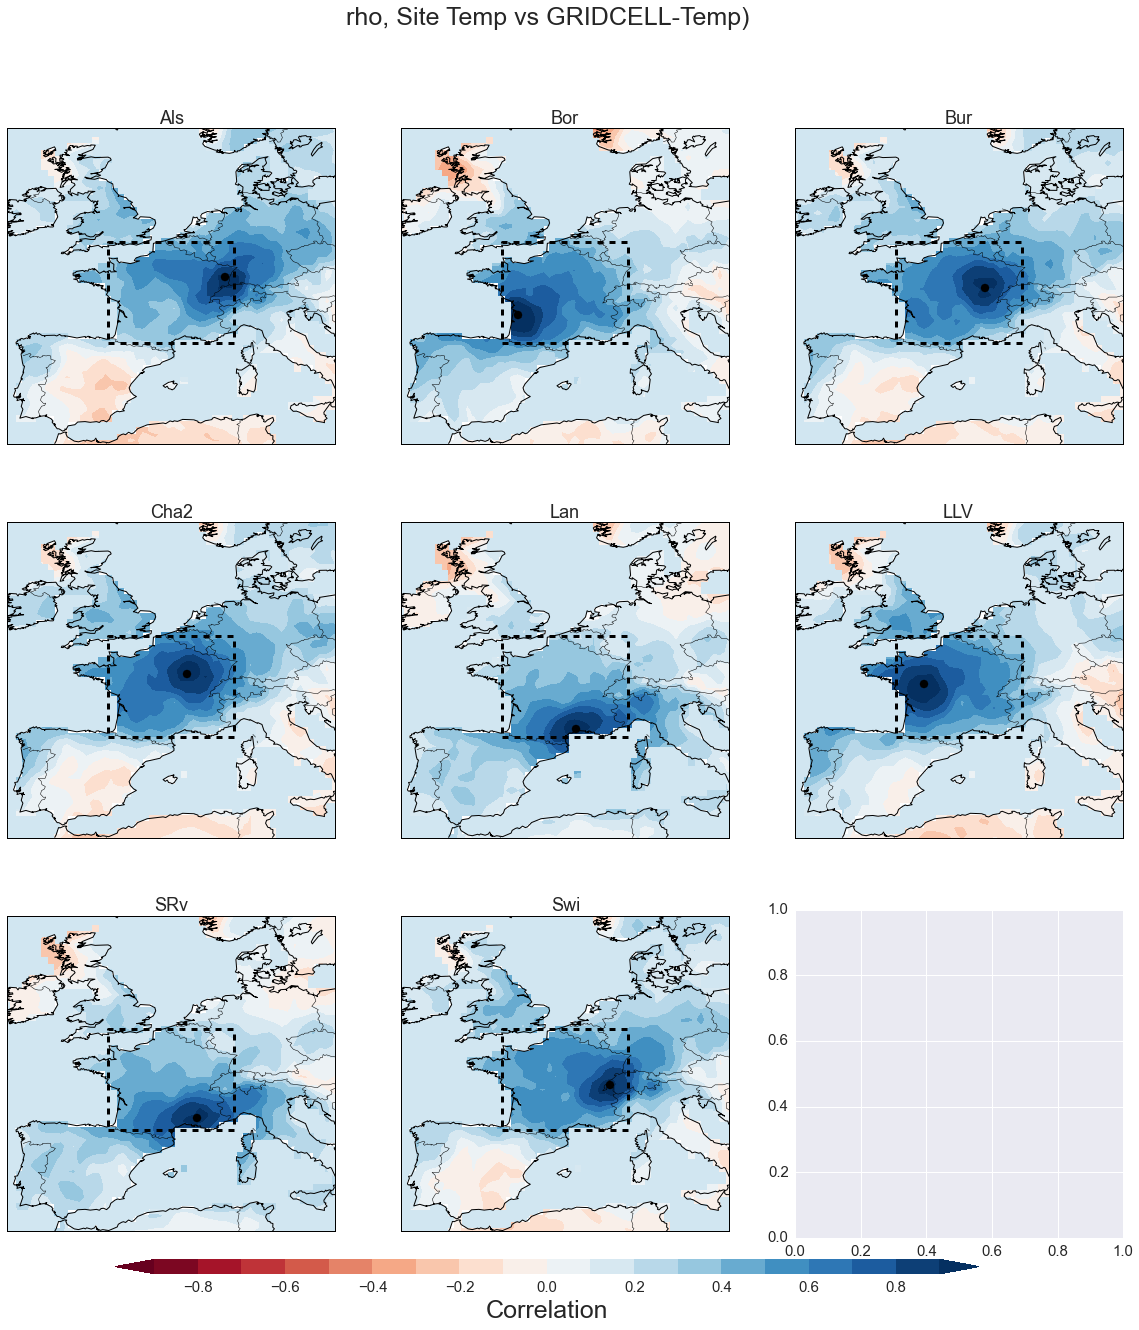

In [88]:
# DEBUG Temp Correlations: Super Figure
# Mapping Parameters
# Set Map Limits and coordinates for mapping
lon_map = lon[i_lon]; lat_map = lat[i_lat];

#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

#site_color = np.float64([140,140,140])/255
site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

numrow=3
numcol=3
figdims=20

# (1) SETUP FIGURE
title_txt = 'rho, Site Temp vs GRIDCELL-Temp)'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))
#    fig = plt.figure(figsize=(20,20))

for ifile in enumerate(ghd_all_names[2:]):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    # corr_field = rho_temp_vs_temp_reg[ifile[0],:,:];
    corr_field = rho_prec_vs_prec_reg[ifile[0],:,:];
    #corr_field = rho_pdsi_vs_pdsi_reg[ifile[0],:,:];

    # Pull out correct lat/lon for this site
    lat_site = df_sitelocs.Latitude[ifile[1]]
    lon_site = df_sitelocs.Longitude[ifile[1]]
    #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    #clevs = [.05,.10,.15,.20,.25,.30,.35,.40,.45,.50,.55,.60,.65,.70,.75,.80,.85,.90,.95]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR TO EACH SUBTITLE
    #cbar = m.colorbar(cs,location='bottom',pad="5%")
    #cbar.set_label('Correlation',fontsize=18)
    #sns.plt.title(ifile[1],fontdict)
    #sns.plt.title(ifile[1],fontdict)
    axcurr.set_title(ifile[1],fontsize=18)
    # (9) SAVE TO OUTPUT
    #plt.show()

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
   # cbar.fontsize(20)
#sns.plt.colorbar(orientation='horizontal') 
#plt.show() 

#cbar = m.colorbar(cs,location='bottom',pad="5%")
#(8) ADD COLORBAR AND TITLE
#cbarax = fig.add_axes([0.1,0.1,0.8,0.8])
#cbar = fig.colorbar(cs,axlocation='bottom',pad="5%")
#cbar.set_label('Correlation',fontsize=18)
sns.plt.suptitle(title_txt,fontsize=25)
#out_txt = '../figures/step03/corrmap.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
#fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator






In [76]:
# Output For Lizzie
if lizzie_out_flag==1:
    # Create Data Frames with Seasonal climate variables (row=years, columns=sitenames)
    df_seas_temp = pd.DataFrame(tmp_coswtmean, index=yr_cru, columns=ghd_all_names)
    df_seas_prec = pd.DataFrame(pre_coswtmean, index=yr_cru, columns=ghd_all_names)
    df_seas_pdsi = pd.DataFrame(pdsi_coswtmean, index=yr_cru, columns=ghd_all_names)

    # Create Output (csv files), and remove (delete) old files
    
    # Temperature
    outfile = '../data/seas_temp_'+mons_ave_txt+'.'+range_txt+'.csv'; 
    if os.path.exists(outfile):
        os.remove(outfile); 
    df_seas_temp.to_csv(outfile,sep=','); print(outfile)
    
    # Precipitation
    outfile = '../data/seas_prec_'+mons_ave_txt+'.'+range_txt+'.csv'; 
    if os.path.exists(outfile):
        os.remove(outfile); 
    df_seas_prec.to_csv(outfile,sep=','); print(outfile)
    
    # PDSI
    outfile = '../data/seas_pdsi_'+mons_ave_txt+'.'+range_txt+'.csv'; 
    if os.path.exists(outfile):
        os.remove(outfile); 
    df_seas_pdsi.to_csv(outfile,sep=','); print(outfile)


In [77]:
# FIXED axis limits to make comparisons easier for GHD-Core and GHD-ALL
if mons_ave_txt=='MJJ':
    print("MJJ Limits")

    # Limits for MJJ
    limit_ghd=np.float64([-40,20]); 
    limit_temp=np.float64([12,20]); 
    limit_prec=np.float64([80,370]); 
    limit_pdsi=np.float64([-5,4])
 
elif mons_ave_txt=='JJA':
    print("JJA Limits")

    # Limits for JJA
    limit_ghd=np.float64([-35,20]); 
    limit_temp=np.float64([14,22]); 
    limit_prec=np.float64([50,375]); 
    limit_pdsi=np.float64([-5,4]);


MJJ Limits


(0, 'GHDmean')
(1, 'GHDcore')


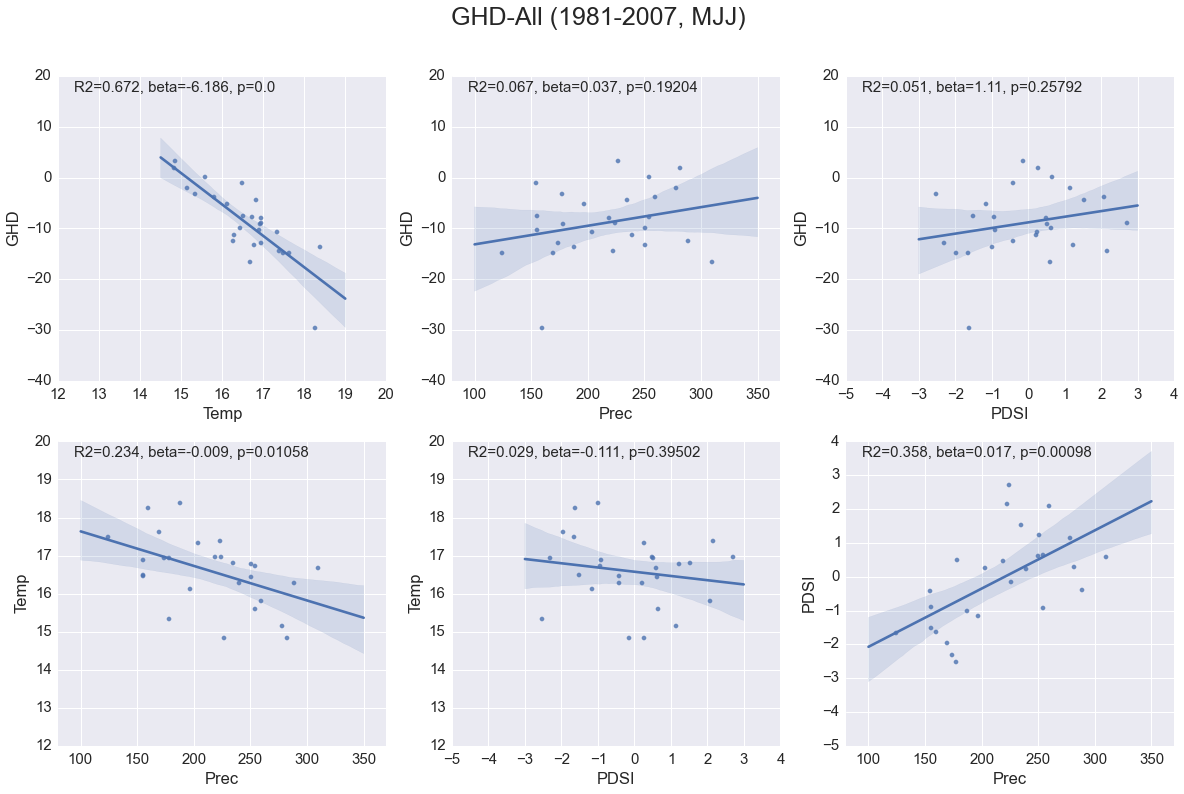

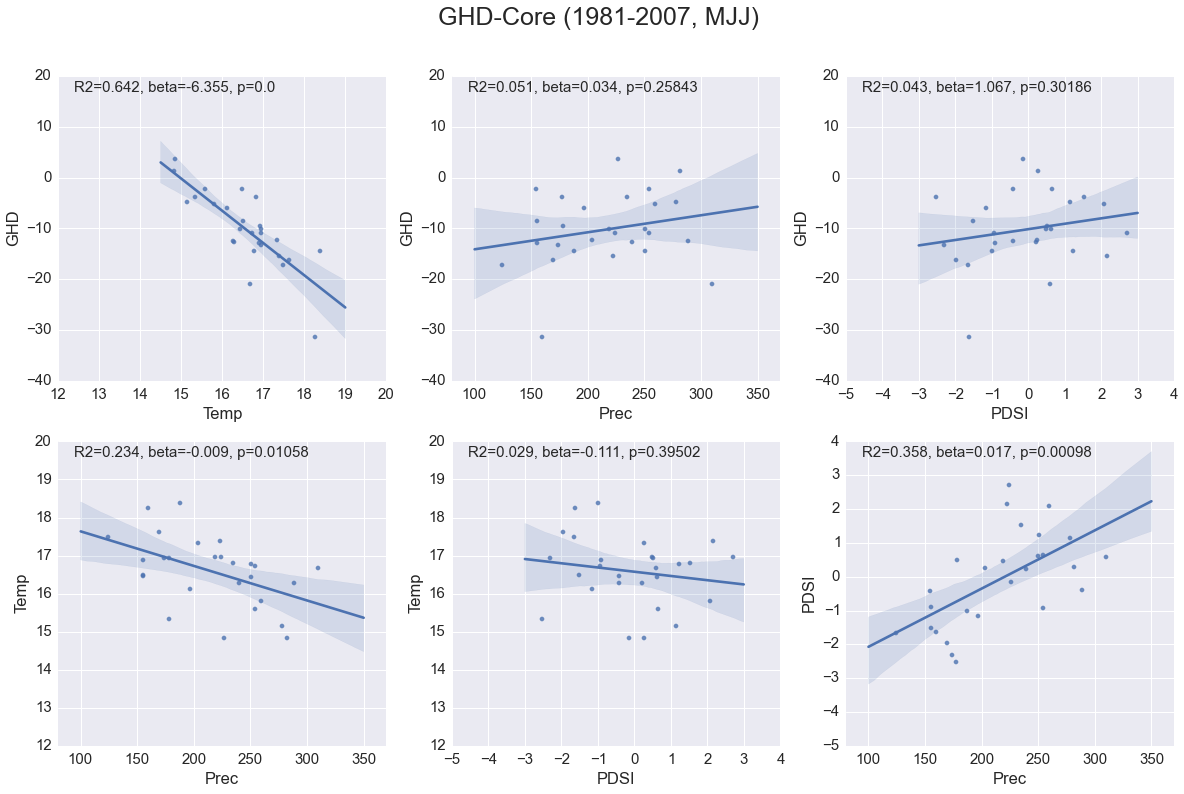

In [78]:
# Here, I will just plot the regressions for GHDcore and GHDmean 

# Regression and scatter plots each GHD Index
for ifile in enumerate(ghd_all_names[0:2]):

    print(ifile)

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]]

    # Create Data Frame
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe
    df_siteclim.GHD = np.float64(ghd)
    df_siteclim.Temp = np.float64(tmp_series)
    df_siteclim.Prec = np.float64(pre_series)
    df_siteclim.PDSI = np.float64(pdsi_series)
    
    # Remove Missing Values (necessary for regression calculation)
    df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Rename Composite Series for the Figures
    if series_name=='GHDmean':
        series_name='GHD-All'
        
    if series_name=='GHDcore':
        series_name='GHD-Core'
        
    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD 
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_temp)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # Subplot #2: Prec vs GHD   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_prec)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
    
    # Subplot #3: PDSI vs GHD   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_ghd)
    sns.plt.xlim(limit_pdsi)  
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
    
    # Subplot #4: Prec vs Temp
    sns.plt.subplot(2,3,4),sns.regplot("Prec","Temp",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_temp)
    sns.plt.xlim(limit_prec) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)     

    # Subplot #5: PDSI vs Temp
    sns.plt.subplot(2,3,5),sns.regplot("PDSI","Temp",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_temp)
    sns.plt.xlim(limit_pdsi) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)        

    # Subplot #6: PDSI vs Prec 
    sns.plt.subplot(2,3,6),sns.regplot("Prec","PDSI",df_siteclim,scatter=True,marker='o')
    sns.plt.ylim(limit_pdsi)
    sns.plt.xlim(limit_prec) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.PDSI)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)      
    
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator   
    
    
    
    

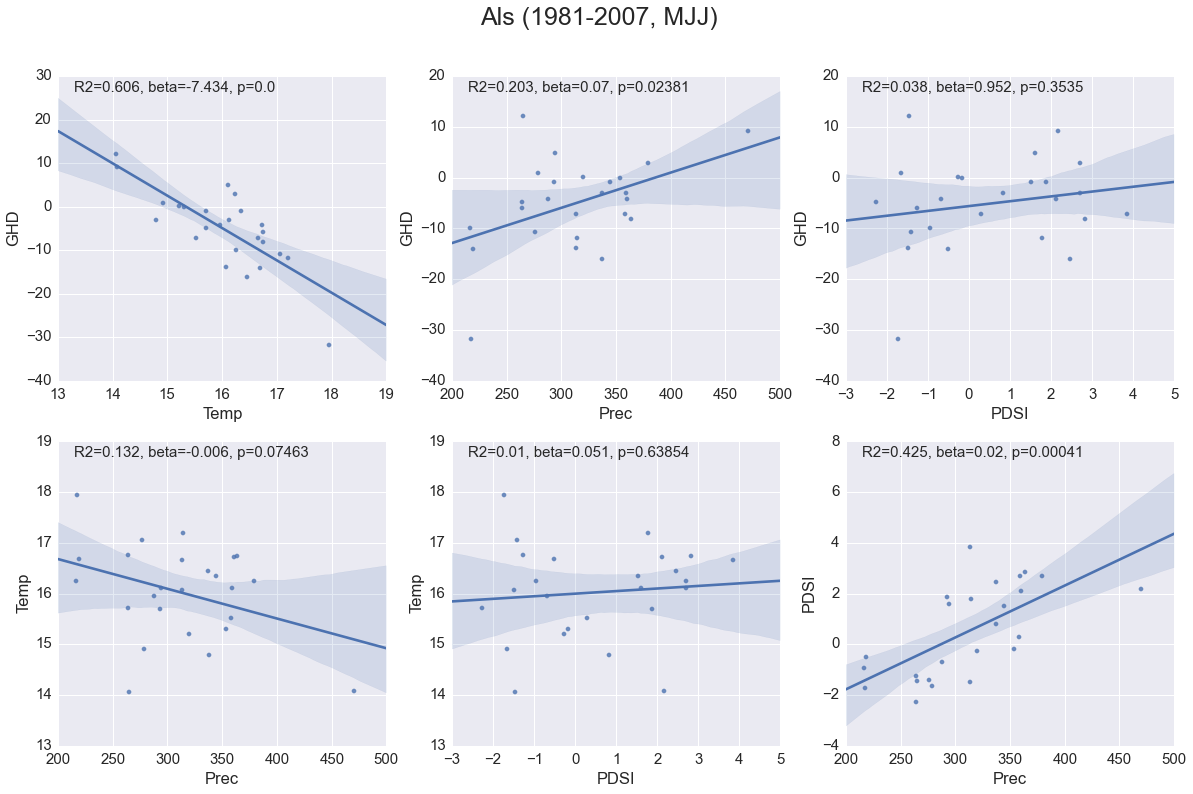

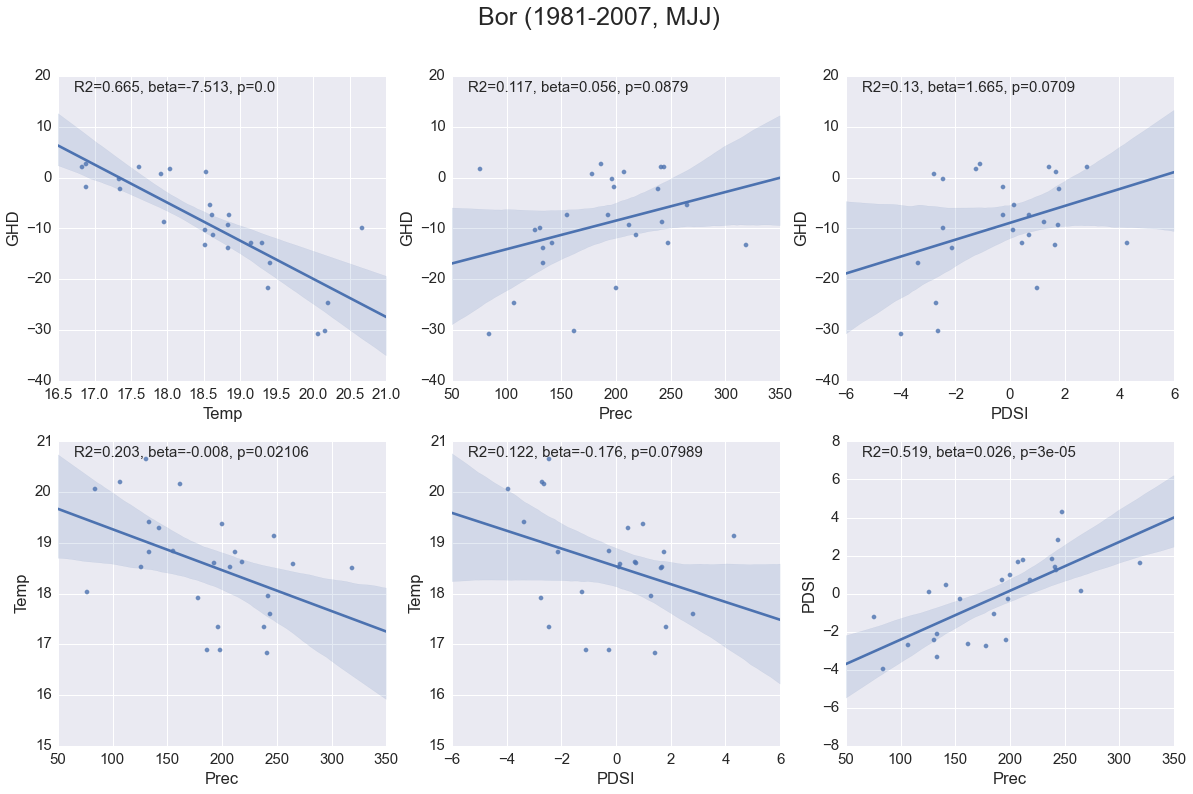

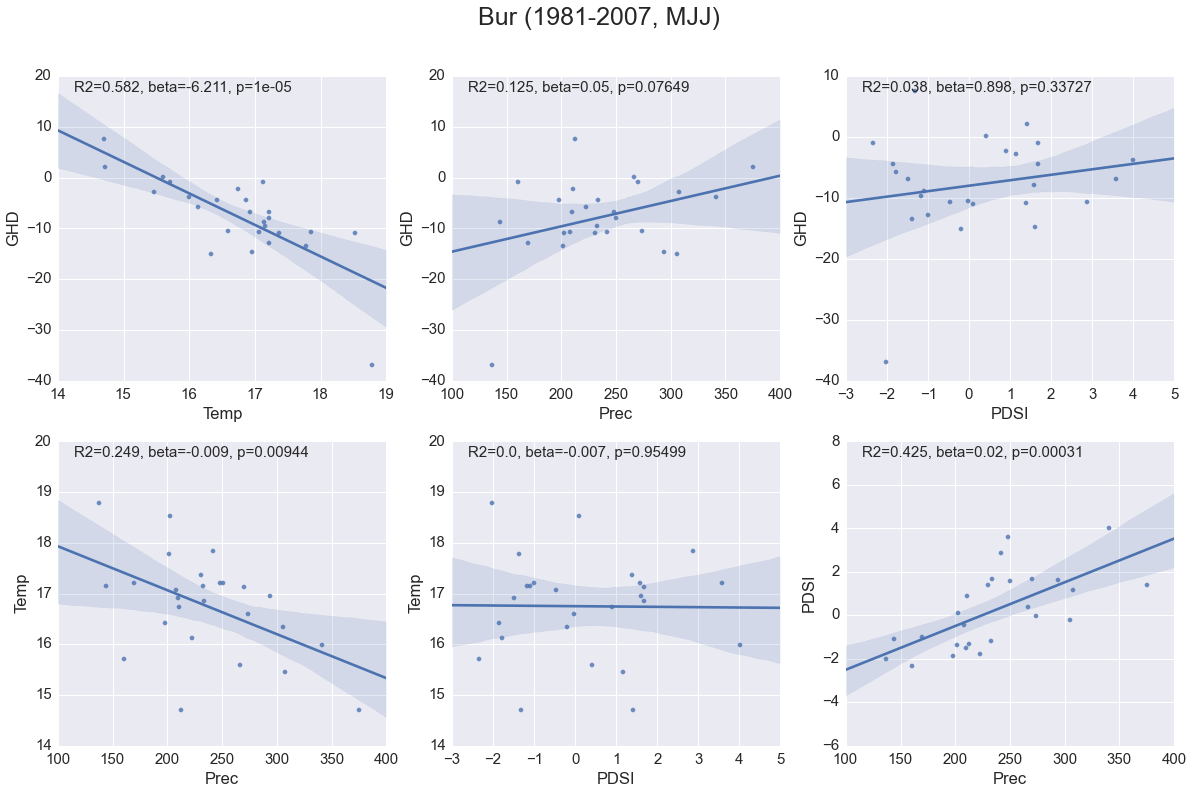

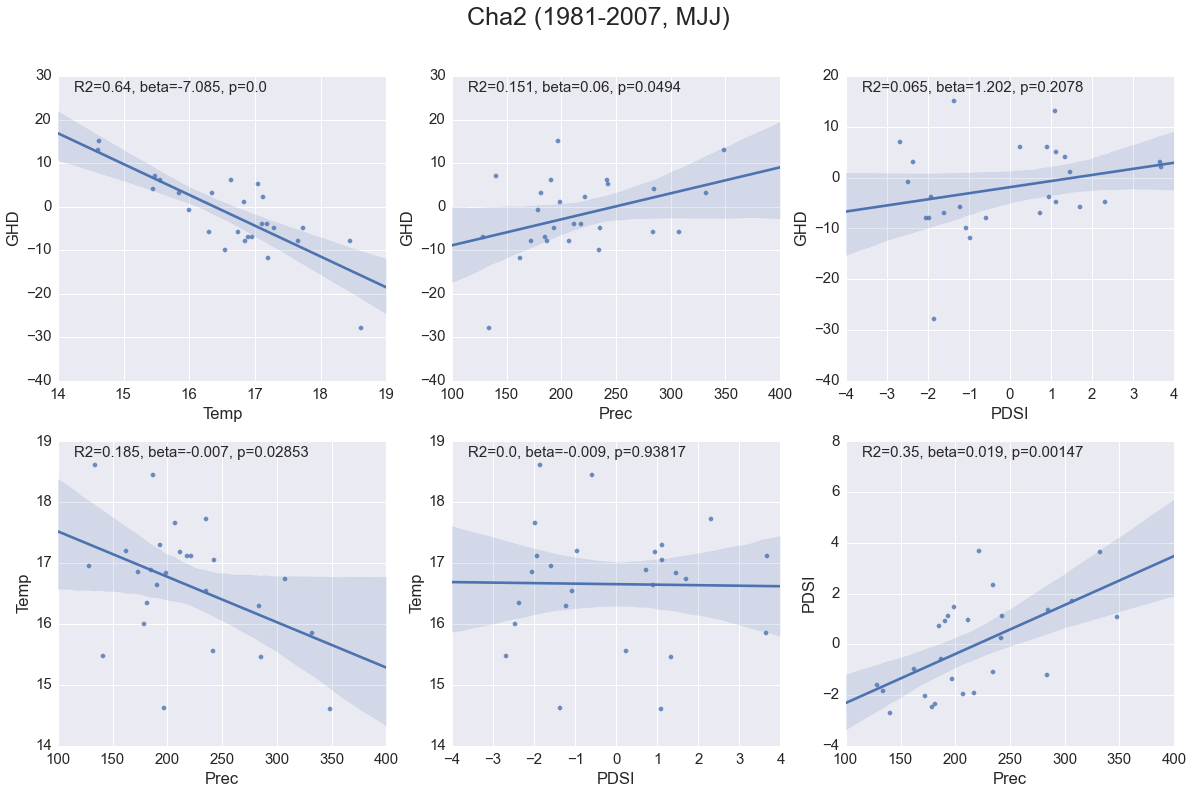

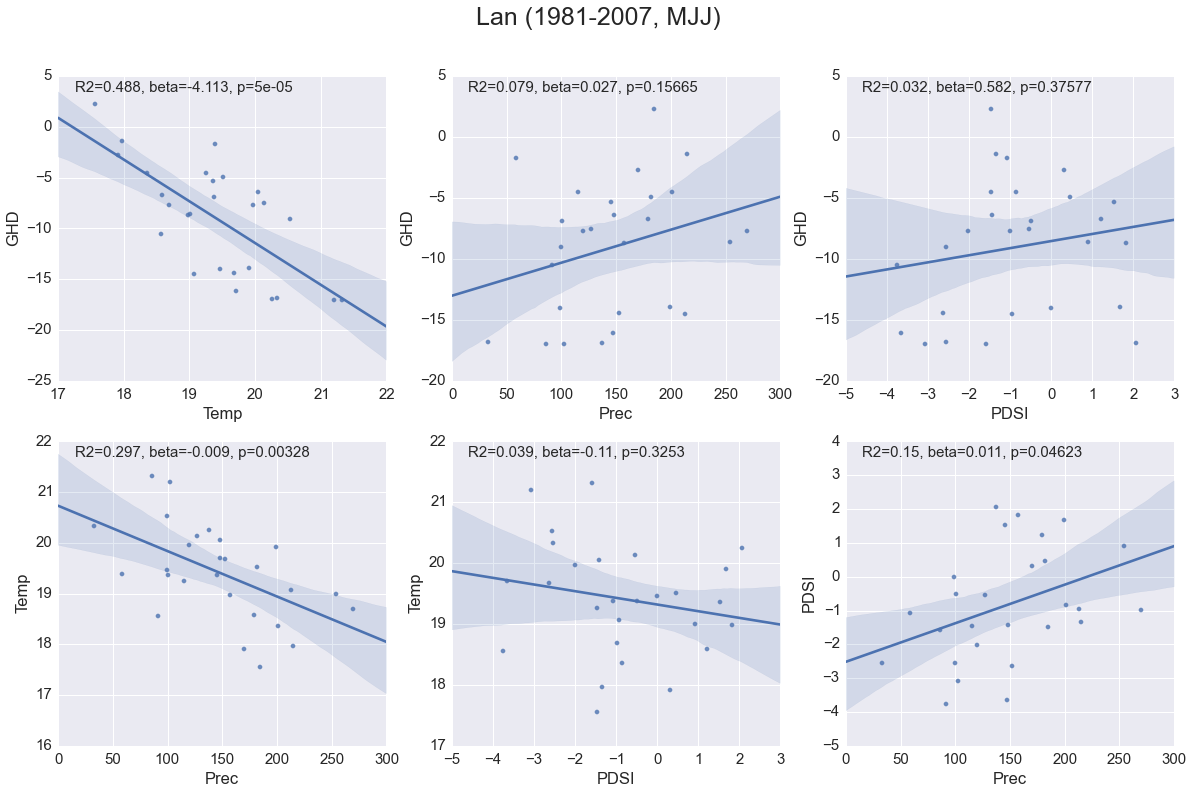

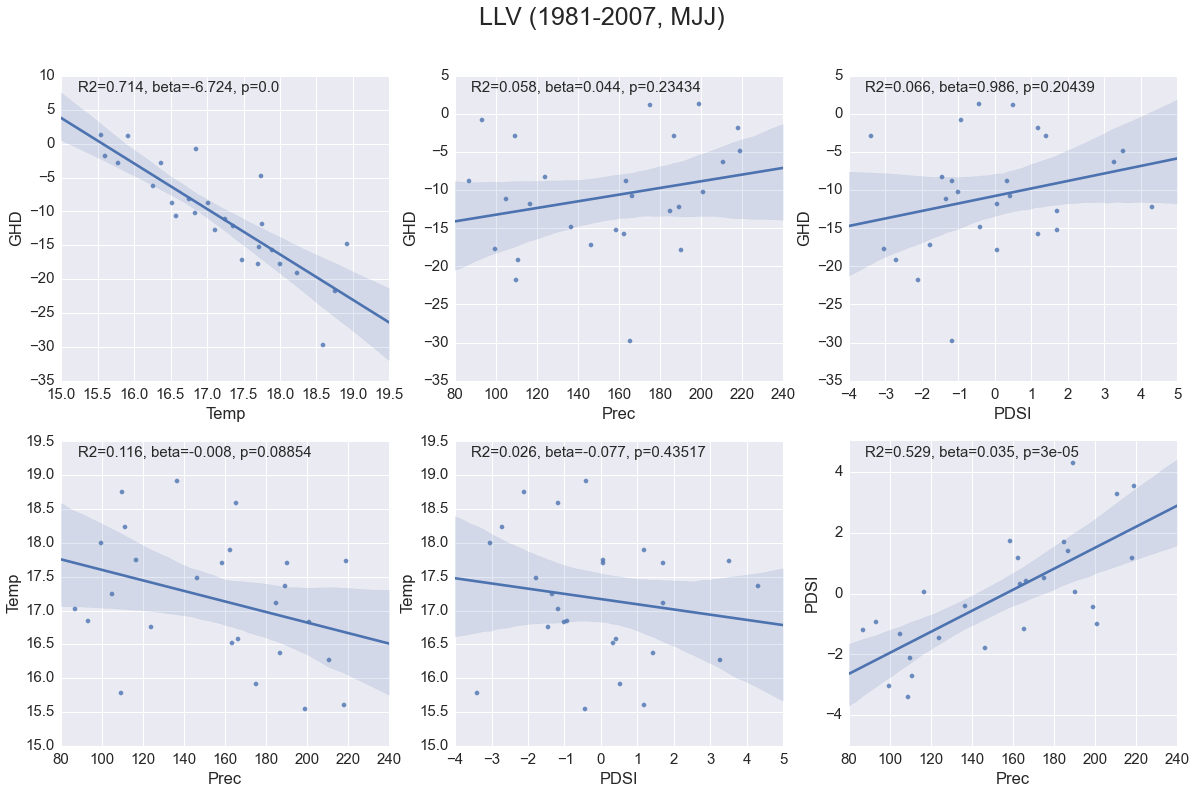

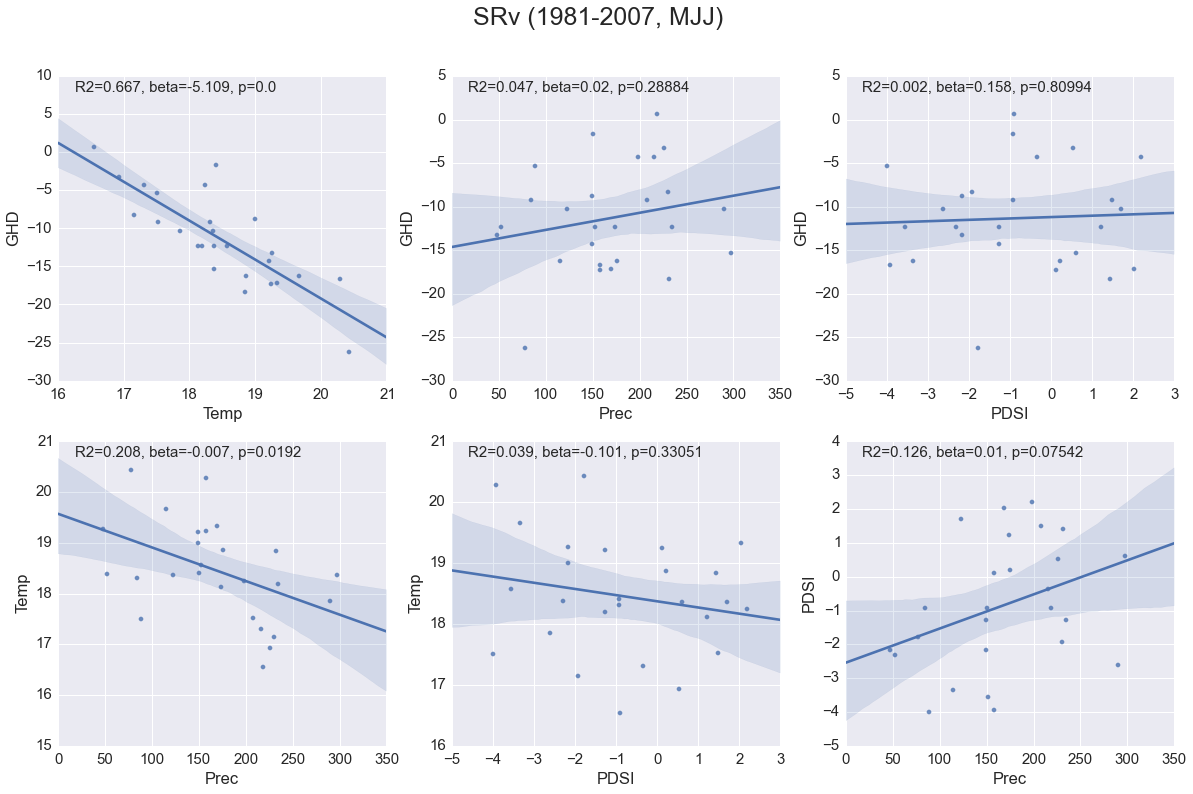

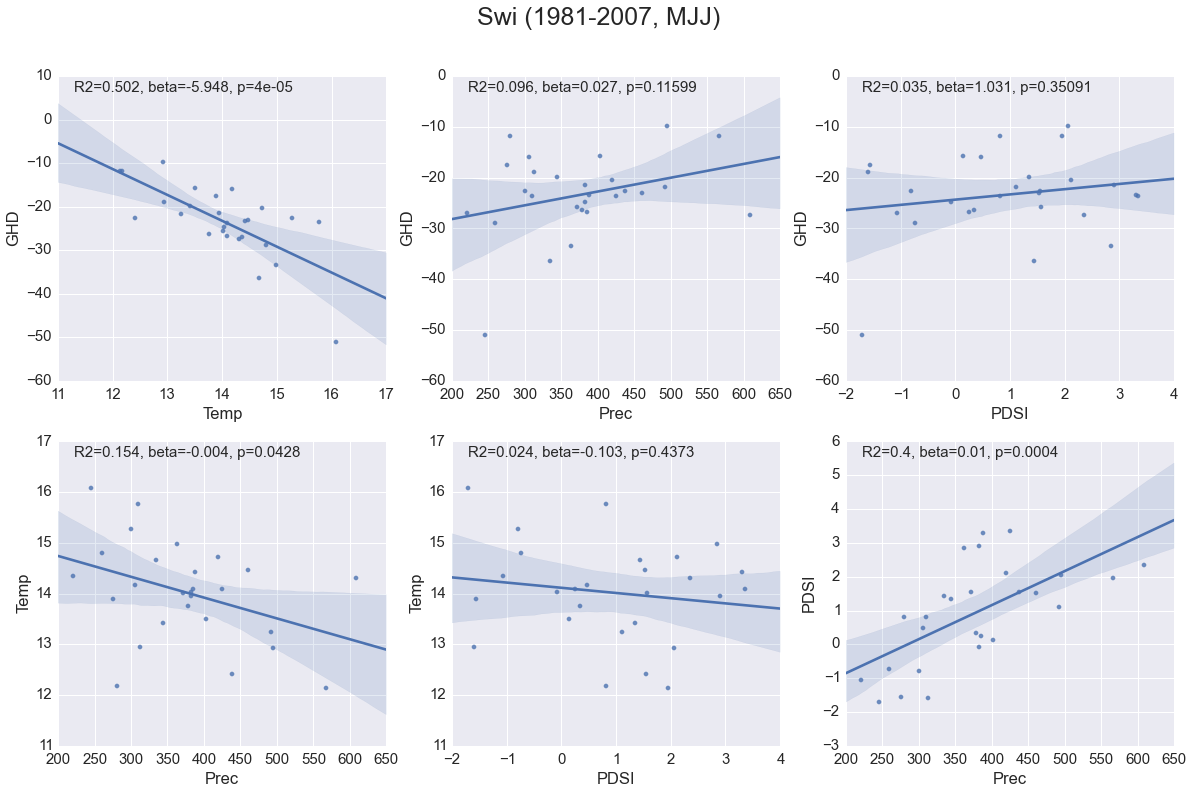

In [79]:
# Regression and scatter plots each GHD Index, INDIVIDUAL SITES ONLY
for ifile in enumerate(ghd_all_names[2:]):
#for ifile in enumerate(ghd_all_names[2:3]):

    #print(tmp_series)

    # Pull out GHD
    ghd=df[ifile[1]]; ghd=ghd[loc_yrs_ghd];
    
    # Pull out Climate Data
    tmp_series  = tmp_coswtmean[loc_yrs_cru,ifile[0]+2]
    pre_series  = pre_coswtmean[loc_yrs_cru,ifile[0]+2]
    pdsi_series = pdsi_coswtmean[loc_yrs_cru,ifile[0]+2]

    # Create Data Frame
    del df_siteclim
    df_siteclim = pd.DataFrame(index=yr_cru[loc_yrs_cru], columns=['GHD','Temp','Prec','PDSI'])
    
    # Populate Dataframe
    df_siteclim.GHD =  copy.deepcopy(np.float64(ghd))
    df_siteclim.Temp = copy.deepcopy(np.float64(tmp_series))
    df_siteclim.Prec = copy.deepcopy(np.float64(pre_series))
    df_siteclim.PDSI = copy.deepcopy(np.float64(pdsi_series))
    
    # Remove Missing Values (necessary for regression calculation)
    df_siteclim=df_siteclim[df_siteclim.GHD.notnull()];
    
    # Series Name 
    series_name = ifile[1]

    # Setup Figure for the Current Site
    sns.set(style="darkgrid")
    sns.set_context("notebook", font_scale=1.5)
    sns.set_context( font_scale=1.5,rc={'lines.markeredgewidth': 0.1})
    sns.plt.figure(figsize=[20,12])
    sns.plt.suptitle(series_name+' ('+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')',fontsize=25)
       
    # Subplot #1: Temp vs GHD 
    sns.plt.subplot(2,3,1),sns.regplot("Temp","GHD",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Temp,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 

    # Subplot #2: Prec vs GHD   
    sns.plt.subplot(2,3,2),sns.regplot("Prec","GHD",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
    
    # Subplot #3: PDSI vs GHD   
    sns.plt.subplot(2,3,3),sns.regplot("PDSI","GHD",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.GHD)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15) 
      
    # Subplot #4: Prec vs Temp
    sns.plt.subplot(2,3,4),sns.regplot("Prec","Temp",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)     

    # Subplot #5: PDSI vs Temp
    sns.plt.subplot(2,3,5),sns.regplot("PDSI","Temp",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.PDSI,df_siteclim.Temp)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)        

    # Subplot #6: PDSI vs Prec 
    sns.plt.subplot(2,3,6),sns.regplot("Prec","PDSI",df_siteclim,scatter=True,marker='o')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_siteclim.Prec,df_siteclim.PDSI)
    R2 = np.round(r_value**2,decimals=3); pval = np.round(p_value, decimals=5); beta = np.round(slope,decimals=3)
    sns.plt.annotate("R2="+np.str(R2)+", beta="+np.str(beta)+", p="+np.str(pval),\
                     xy=(0.05,0.95),xycoords="axes fraction",fontsize=15)      
    
    sns.plt.tight_layout
    sns.plt.savefig('../figures/step03/'+series_name+'.time.vs.all.'+mons_ave_txt+'.'+np.str(yr1[0])+ \
                    '-'+np.str(yr2[0])+'.'+range_txt+'.svg', format='svg', dpi=300) # vector graphics for adobe illustrator 



In [80]:
# Point by Point Correlations Between CRU Data and the GHD Series
# Now, Correlations With GHD
# Initialize Matrices for Correlation Results
rho_ghd_pdsi  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_pdsi[:]=np.NAN
pval_ghd_pdsi = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); pval_ghd_pdsi[:]=np.NAN

rho_ghd_temp  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_temp[:]=np.NAN
pval_ghd_temp = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); pval_ghd_temp[:]=np.NAN

rho_ghd_prec  = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); rho_ghd_prec[:]=np.NAN
pval_ghd_prec = np.zeros((np.size(ghd_all_names),np.size(i_lat),np.size(i_lon))); pval_ghd_prec[:]=np.NAN

# Pull Out All The Sites Names
site_names = df_sitelocs.Location

# Loop through each GHD site individually-------------------------------------------------------------------------------------
for ifile in enumerate(ghd_all_names):
    # Counter
    print(ifile)
    
    # Pull out Current GHD Series for This Site
    ghd_mean = np.float64(df[ifile[1]]);  
    
    # Trim Years to the time period I want to investigate
    ghd_mean = ghd_mean[loc_yrs_ghd];     
    
    # index for real values (not missing)
    realvals = np.where(~np.isnan(ghd_mean))[0]
    
    # Linearly detrend the GHD data
    ghd_detrend = scipy.signal.detrend(ghd_mean[realvals])
    
# Loop through each gridcell of climate data and calculate the correlations---------------------------------------------------
    for n_lat in enumerate(i_lat):
        for n_lon in enumerate(i_lon):
    
            # Pull out Individual gridcell pdsi/temp/prec
            pdsi_seas_cell = pdsi_seas[loc_yrs_cru,n_lat[0],n_lon[0]]
            temp_seas_cell = tmp_seas_ave[loc_yrs_cru,n_lat[0],n_lon[0]]
            prec_seas_cell = pre_seas_sum[loc_yrs_cru,n_lat[0],n_lon[0]]

            # Linearly Detrend Prior to Correlation
            pdsi_cell_detrend = scipy.signal.detrend(pdsi_seas_cell[realvals])
            tmp_cell_detrend  = scipy.signal.detrend(temp_seas_cell[realvals])
            pre_cell_detrend  = scipy.signal.detrend(prec_seas_cell[realvals])

            # Put in NaN if ocean areas (missing values)
            if temp_seas_cell[0]>1000:
                    
                rho_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                pval_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]] = np.nan
       
                rho_ghd_temp[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                pval_ghd_temp[ifile[0],n_lat[0],n_lon[0]] = np.nan

                rho_ghd_prec[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                pval_ghd_prec[ifile[0],n_lat[0],n_lon[0]] = np.nan
            
            else:   
            
                # Spearman rank correlations: PDSI
                rho,pval = stats.spearmanr(pdsi_cell_detrend,ghd_detrend)    
                rho_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]]  = rho
                pval_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]] = pval
                 
                # Spearman rank correlations: Temp
                rho,pval = stats.spearmanr(tmp_cell_detrend,ghd_detrend)    
                rho_ghd_temp[ifile[0],n_lat[0],n_lon[0]]  = rho
                pval_ghd_temp[ifile[0],n_lat[0],n_lon[0]] = pval
        
                # Spearman rank correlations: Prec
                rho,pval = stats.spearmanr(pre_cell_detrend,ghd_detrend)    
                rho_ghd_prec[ifile[0],n_lat[0],n_lon[0]]  = rho
                pval_ghd_prec[ifile[0],n_lat[0],n_lon[0]] = pval        
   
                # More missing gridcells from PDSI Dataset
                if pdsi_seas_cell[0]>1000:
                    rho_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]]  = np.nan
                    pval_ghd_pdsi[ifile[0],n_lat[0],n_lon[0]] = np.nan


(0, 'GHDmean')
(1, 'GHDcore')
(2, 'Als')
(3, 'Bor')
(4, 'Bur')
(5, 'Cha2')
(6, 'Lan')
(7, 'LLV')
(8, 'SRv')
(9, 'Swi')


In [81]:
# Mapping Parameters
# Set Map Limits and coordinates for mapping
lon_map = lon[i_lon]; lat_map = lat[i_lat];

#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

#site_color = np.float64([140,140,140])/255
site_color = np.float64([0,0,0])/255

# Title info
fontdict = {'fontsize': 18}

# Set Row and Column Size based on number of Points I'm Correlating
if np.size(ghd_all_names)<=9:
    numrow=3
    numcol=3
    figdims=20
elif np.size(ghd_all_names)>=10:
    numrow=4
    numcol=4
    figdims=30
    

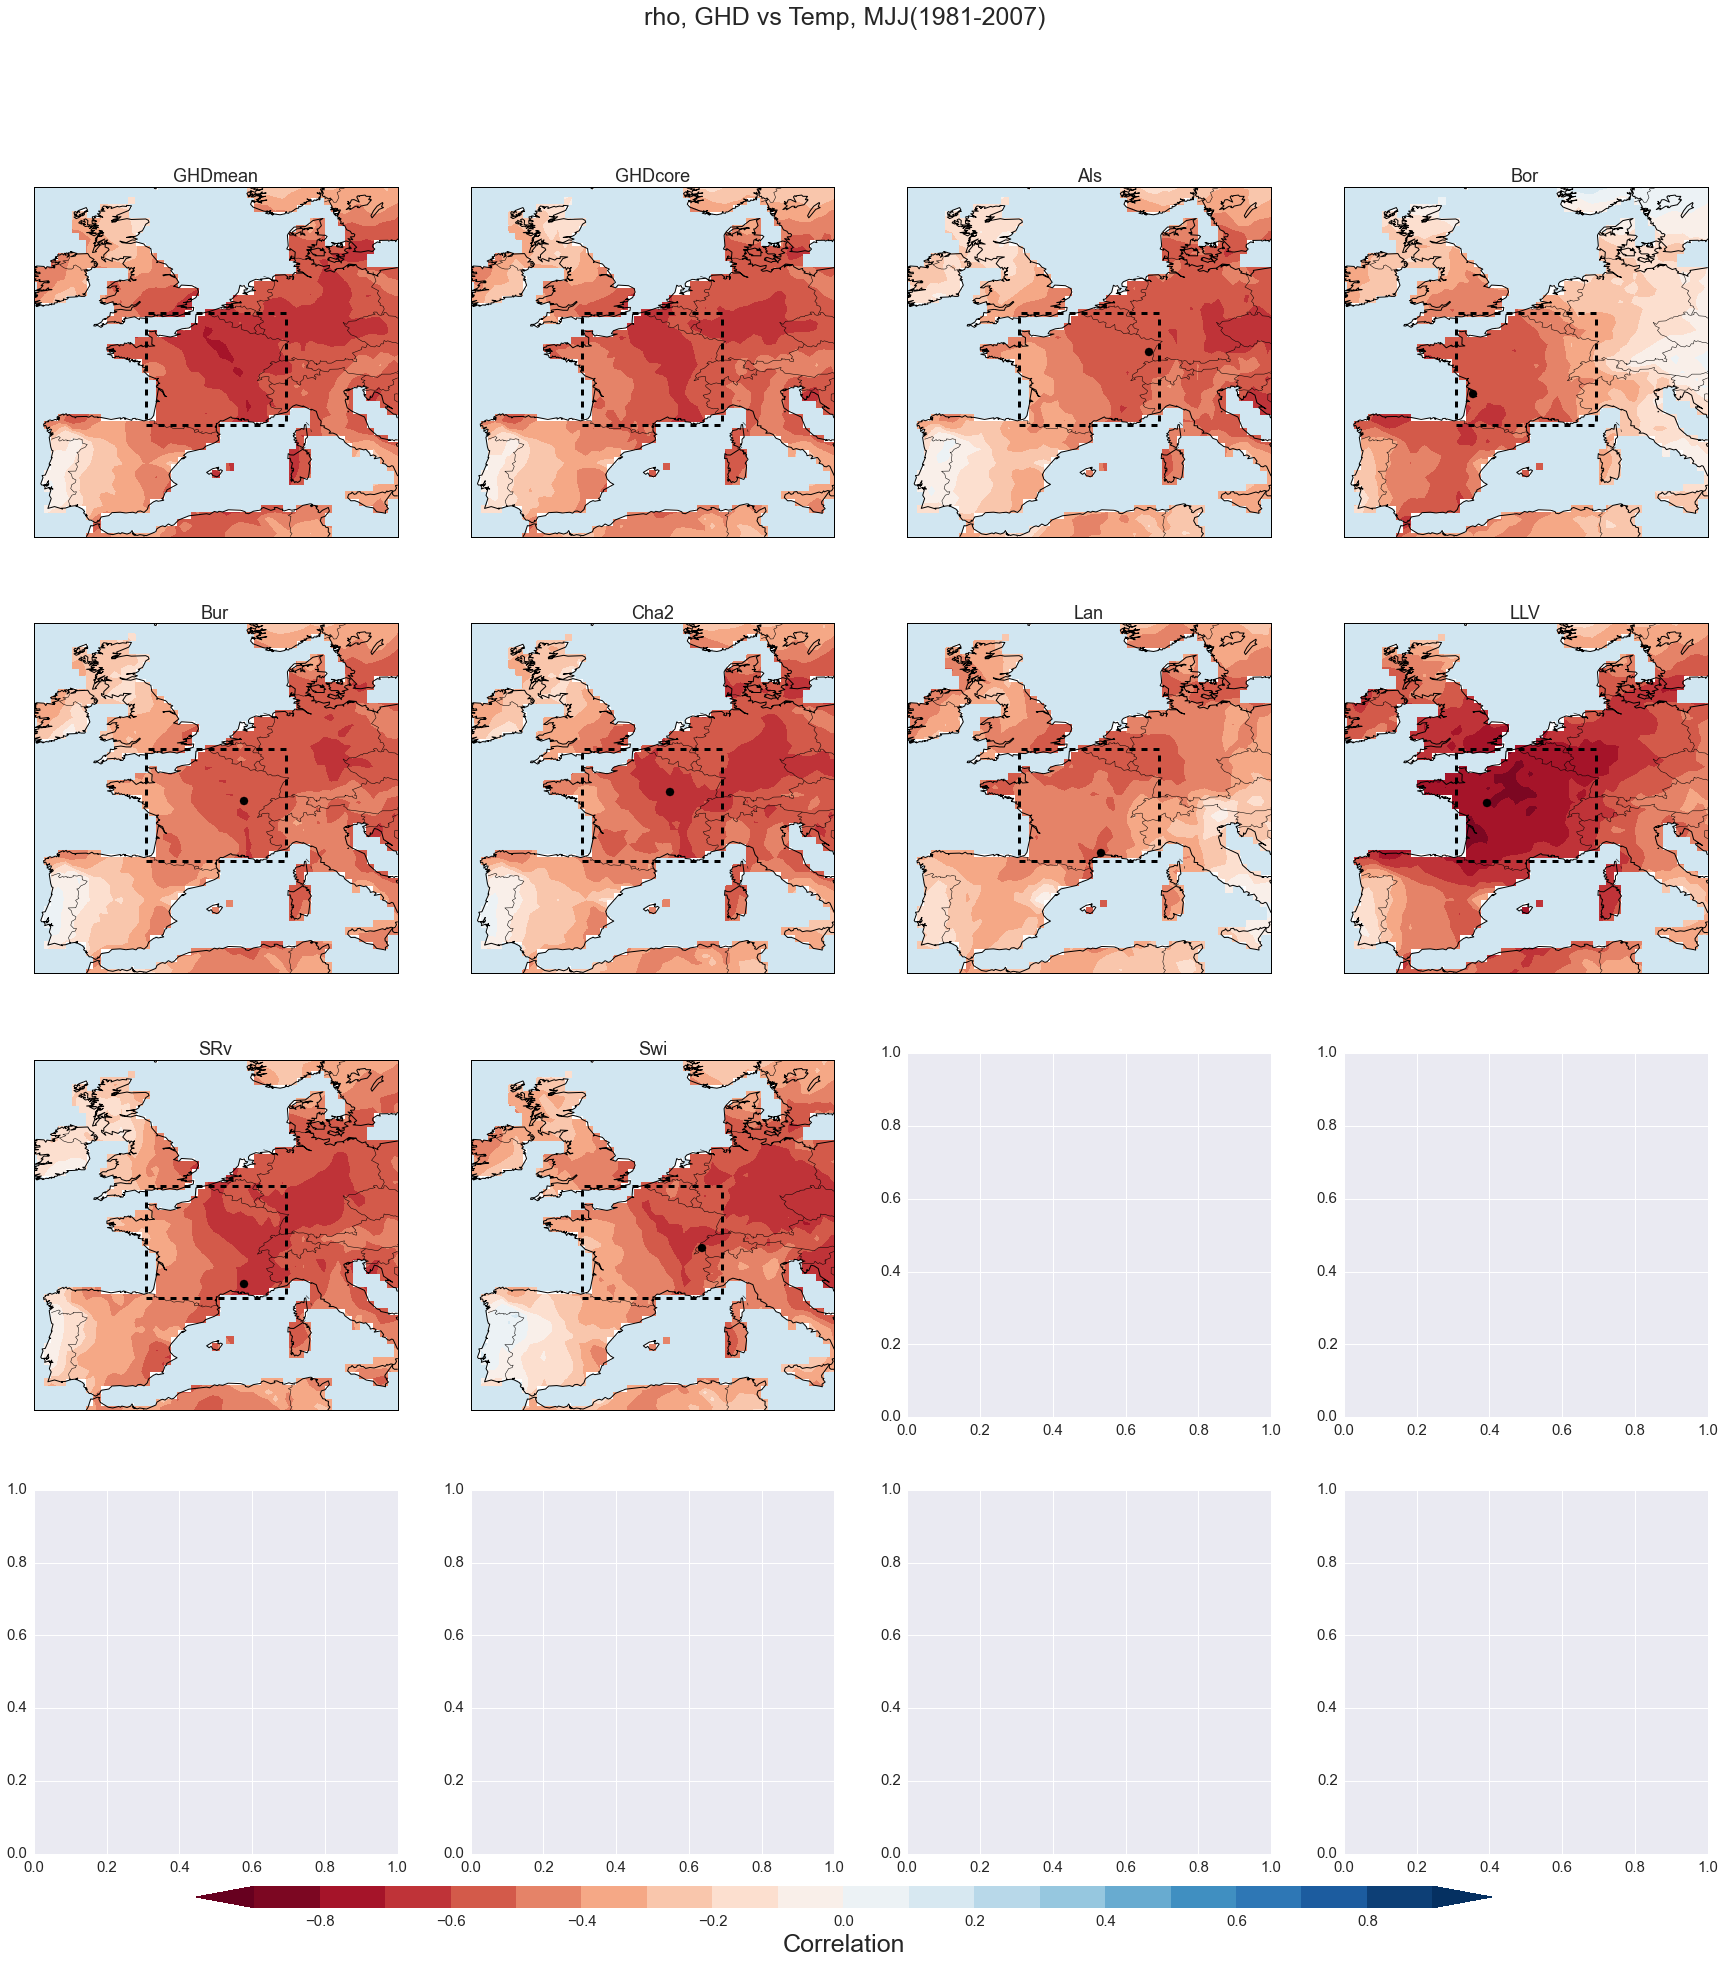

In [82]:
# Temp Correlations: Super Figure, All Sites

# (1) SETUP FIGURE
title_txt = 'rho, GHD vs Temp, '+mons_ave_txt+'('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

# Size of Figure
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))
#    fig = plt.figure(figsize=(20,20))

for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_temp[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR TO EACH SUBTITLE
    #cbar = m.colorbar(cs,location='bottom',pad="5%")
    #cbar.set_label('Correlation',fontsize=18)
    #sns.plt.title(ifile[1],fontdict)
    #sns.plt.title(ifile[1],fontdict)
    axcurr.set_title(ifile[1],fontsize=18)
    # (9) SAVE TO OUTPUT
    #plt.show()

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
   # cbar.fontsize(20)
#sns.plt.colorbar(orientation='horizontal') 
#plt.show() 

#cbar = m.colorbar(cs,location='bottom',pad="5%")
#(8) ADD COLORBAR AND TITLE
#cbarax = fig.add_axes([0.1,0.1,0.8,0.8])
#cbar = fig.colorbar(cs,axlocation='bottom',pad="5%")
#cbar.set_label('Correlation',fontsize=18)
sns.plt.suptitle(title_txt,fontsize=25)
out_txt = '../figures/step03/corrmap.ghd.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator





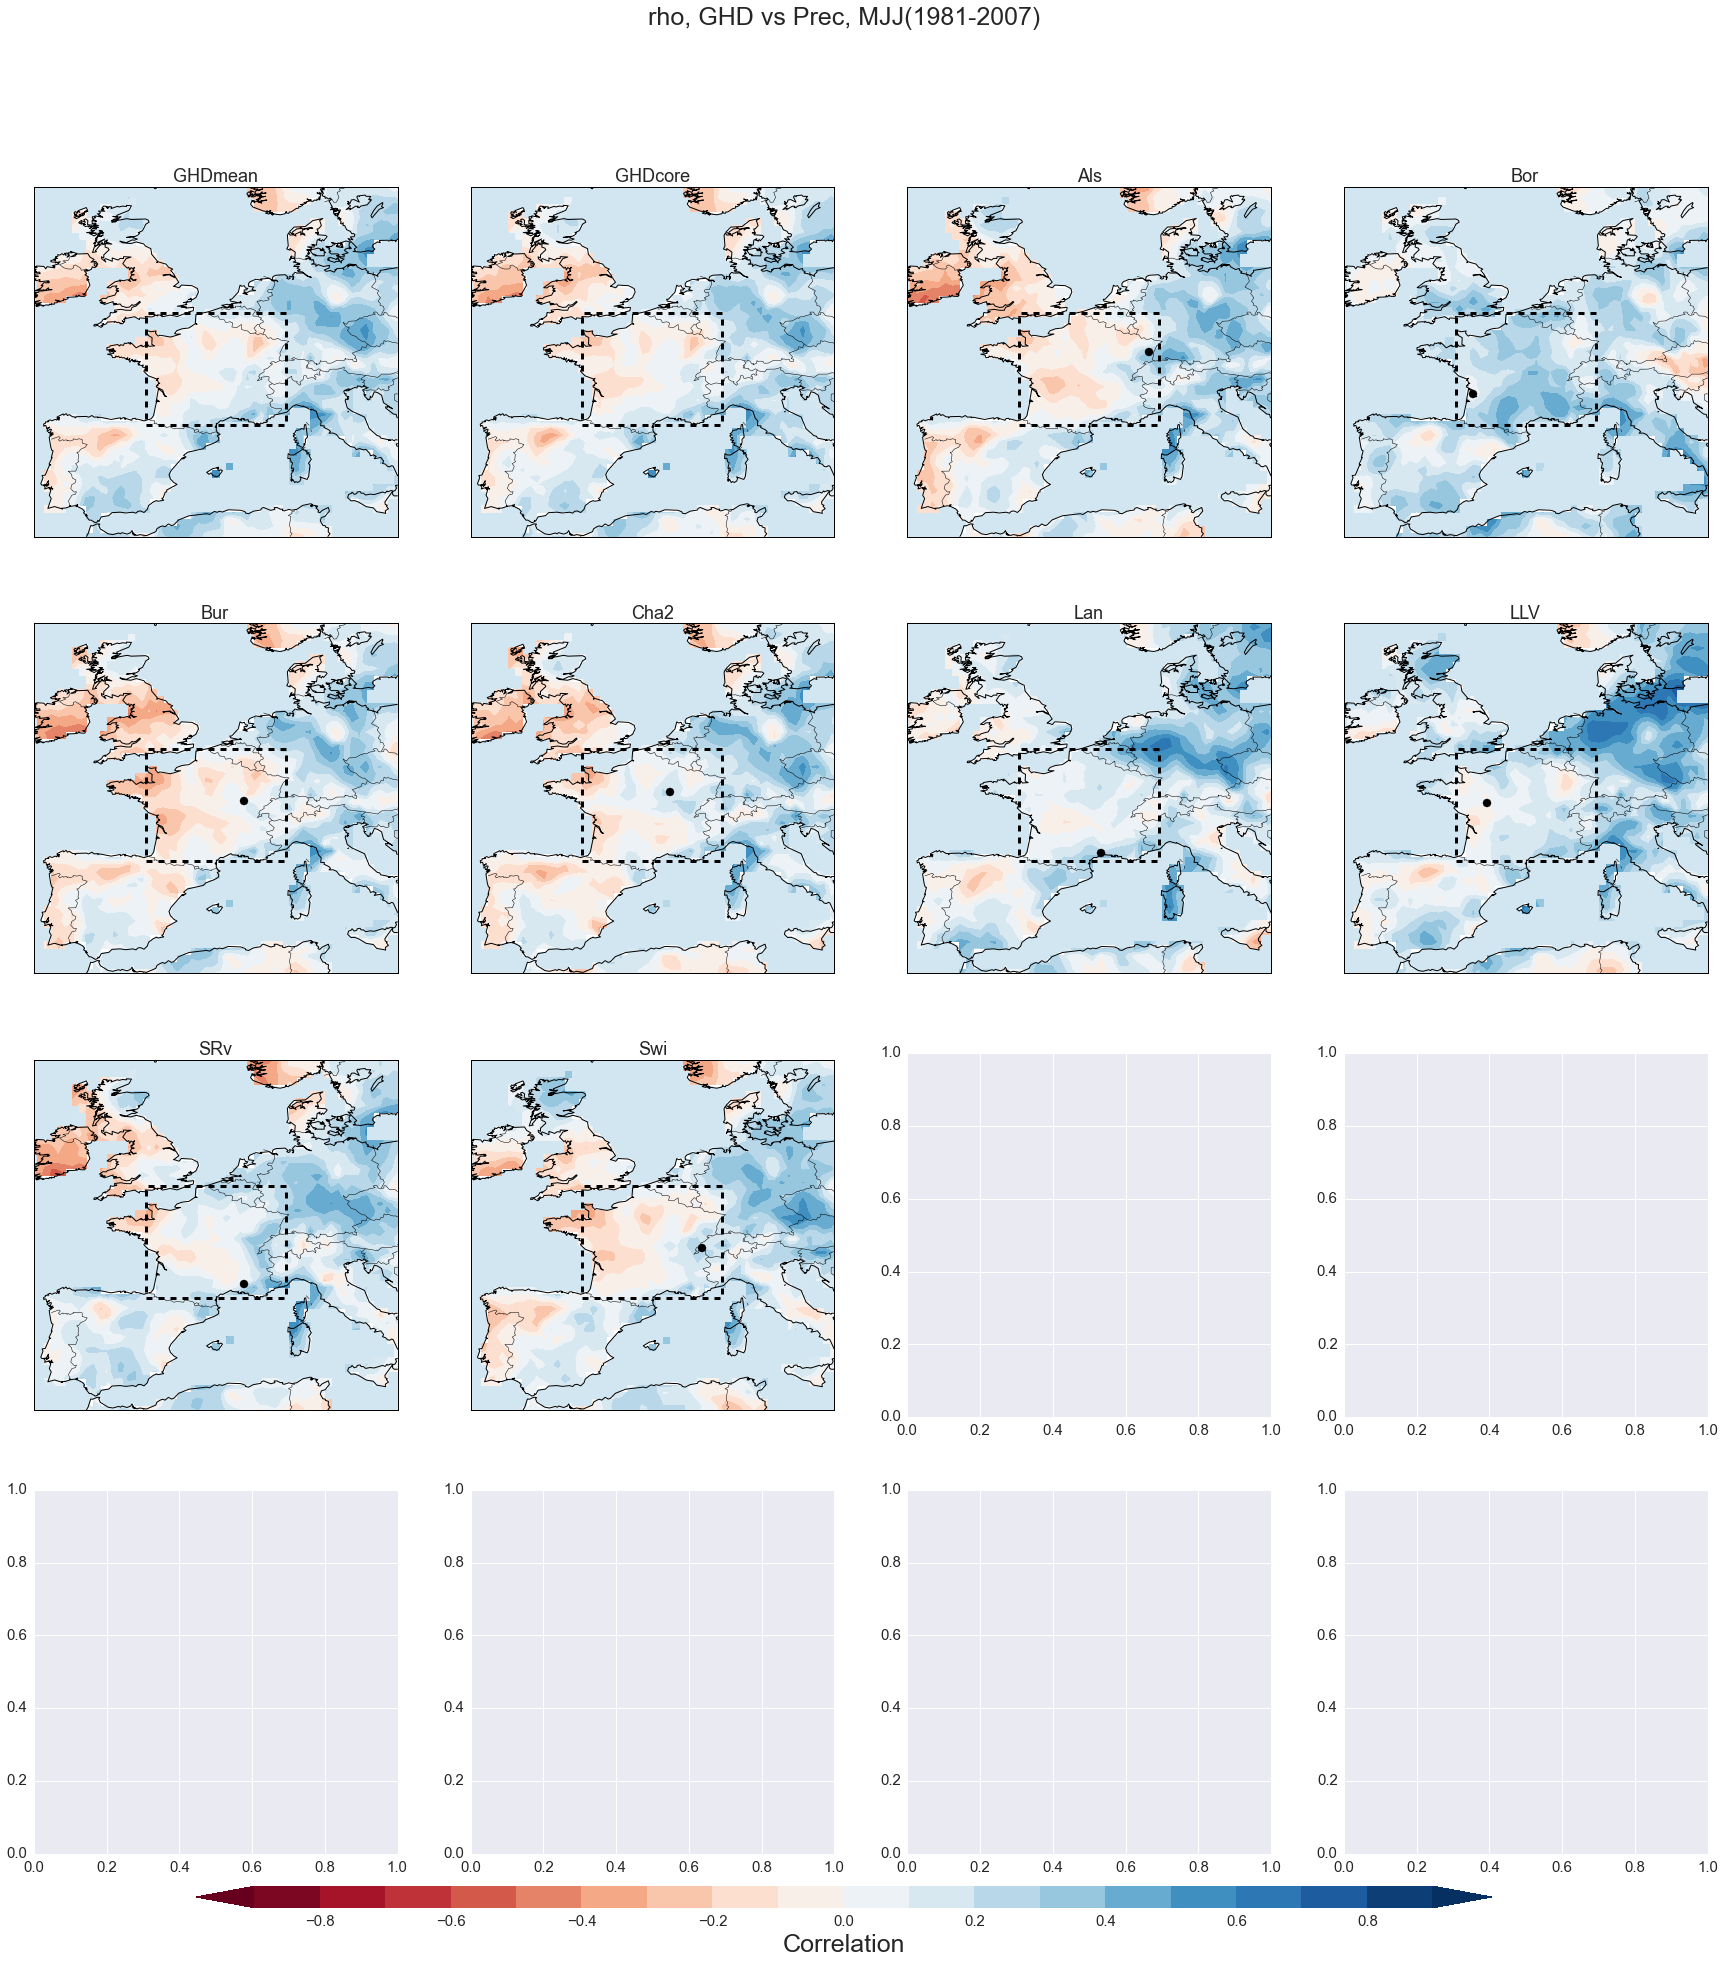

In [83]:
# PREC Correlations: Super Figure, All Sites

# (1) SETUP FIGURE
title_txt = 'rho, GHD vs Prec, '+mons_ave_txt+'('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

#fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))
#    fig = plt.figure(figsize=(20,20))


for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_prec[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR TO EACH SUBTITLE
    #cbar = m.colorbar(cs,location='bottom',pad="5%")
    #cbar.set_label('Correlation',fontsize=18)
    #sns.plt.title(ifile[1],fontdict)
    #sns.plt.title(ifile[1],fontdict)
    axcurr.set_title(ifile[1],fontsize=18)
    # (9) SAVE TO OUTPUT
    #plt.show()

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
   # cbar.fontsize(20)
#sns.plt.colorbar(orientation='horizontal') 
#plt.show() 

#cbar = m.colorbar(cs,location='bottom',pad="5%")
#(8) ADD COLORBAR AND TITLE
#cbarax = fig.add_axes([0.1,0.1,0.8,0.8])
#cbar = fig.colorbar(cs,axlocation='bottom',pad="5%")
#cbar.set_label('Correlation',fontsize=18)
sns.plt.suptitle(title_txt,fontsize=25)
out_txt = '../figures/step03/corrmap.ghd.vs.prec.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator







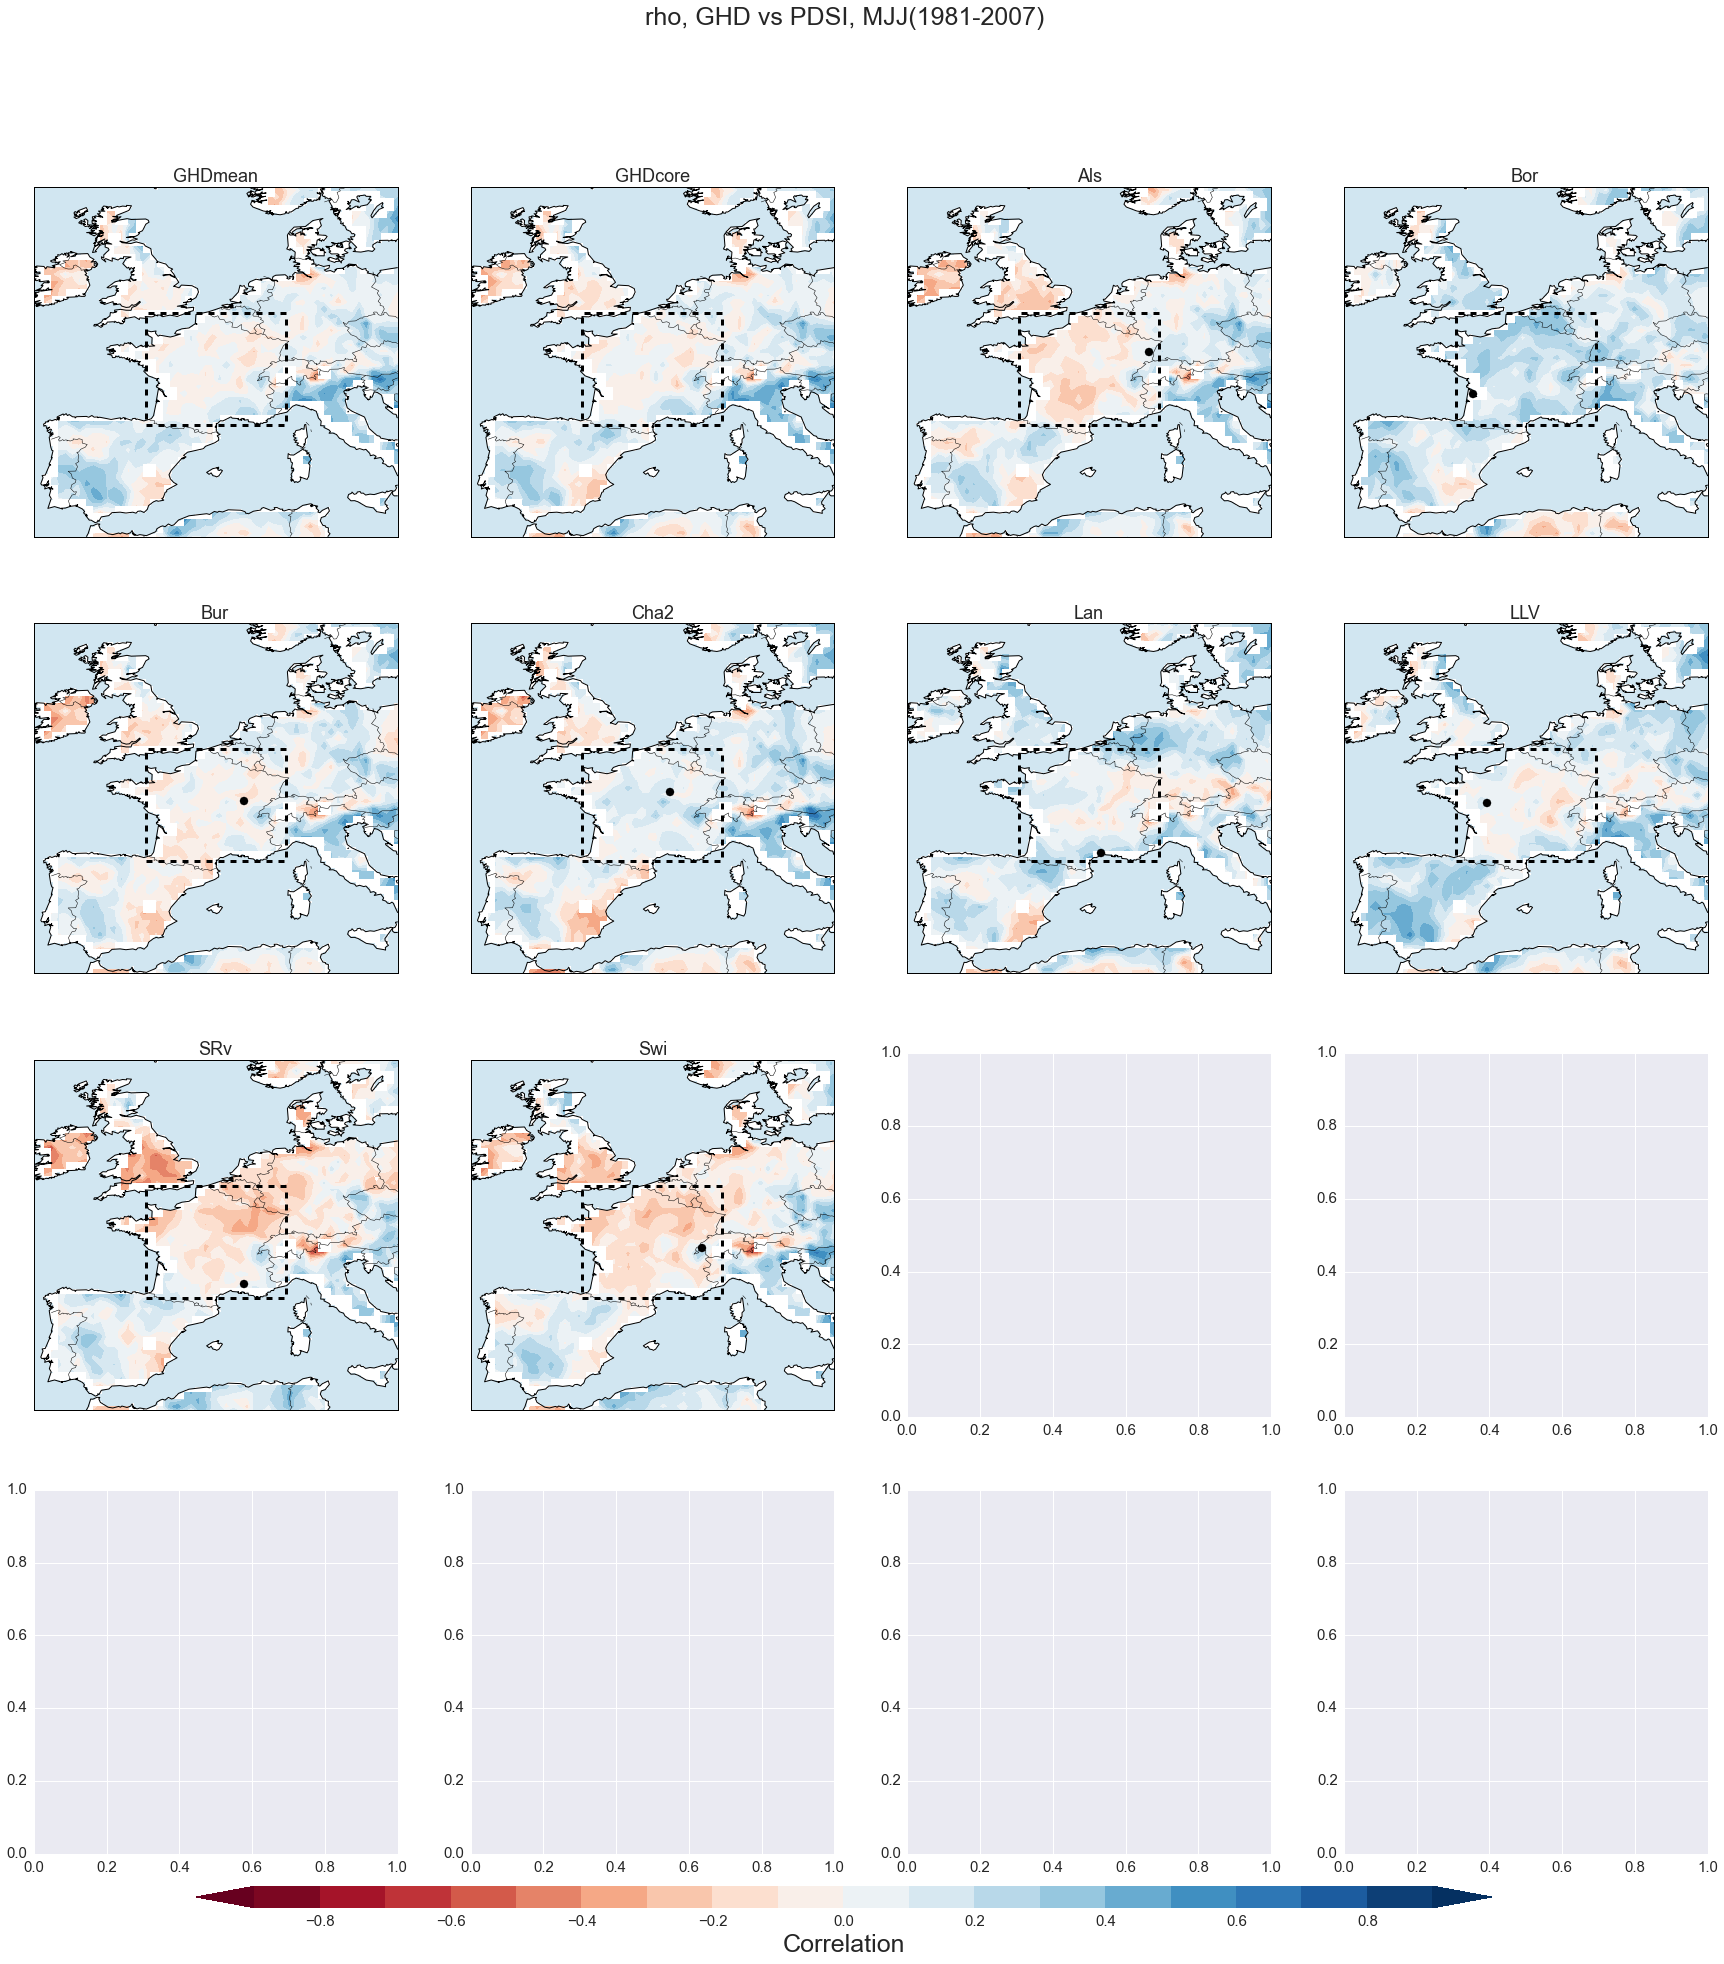

In [84]:
# PDSI Correlations: Super Figure, All Sites

# (1) SETUP FIGURE
title_txt = 'rho, GHD vs PDSI, '+mons_ave_txt+'('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'

#fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
fig, axes = plt.subplots(nrows=numrow, ncols=numcol, figsize=(figdims,figdims))
#    fig = plt.figure(figsize=(20,20))


for ifile in enumerate(ghd_all_names):
    #print(ifile)
    axcurr = axes.flat[ifile[0]];
    
    #print(axcurr)
    # Pull out current correlation field
    corr_field = rho_ghd_pdsi[ifile[0],:,:];
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        #print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))
    
    #sns.plt.subplot(3,3,ifile[0])
    #ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim),ax=axcurr)
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR TO EACH SUBTITLE
    #cbar = m.colorbar(cs,location='bottom',pad="5%")
    #cbar.set_label('Correlation',fontsize=18)
    #sns.plt.title(ifile[1],fontdict)
    #sns.plt.title(ifile[1],fontdict)
    axcurr.set_title(ifile[1],fontsize=18)
    # (9) SAVE TO OUTPUT
    #plt.show()

# Save Figure
cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Correlation',fontsize=25)
cbar.ax.ticklabel_format(label_size=20)
   # cbar.fontsize(20)
#sns.plt.colorbar(orientation='horizontal') 
#plt.show() 

#cbar = m.colorbar(cs,location='bottom',pad="5%")
#(8) ADD COLORBAR AND TITLE
#cbarax = fig.add_axes([0.1,0.1,0.8,0.8])
#cbar = fig.colorbar(cs,axlocation='bottom',pad="5%")
#cbar.set_label('Correlation',fontsize=18)
sns.plt.suptitle(title_txt,fontsize=25)
out_txt = '../figures/step03/corrmap.ghd.vs.pdsi.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator






(0, 'GHDcore')
GHDcore: 0.0, 0.0


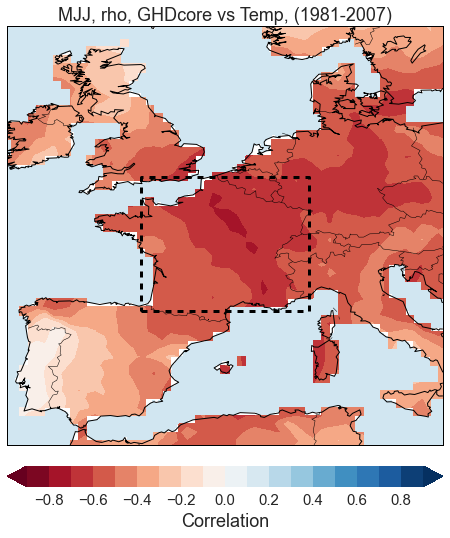

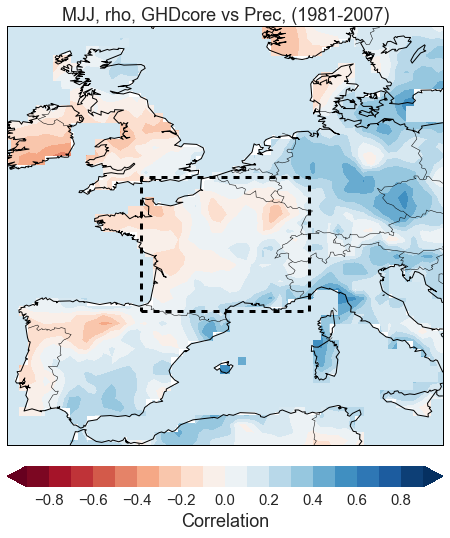

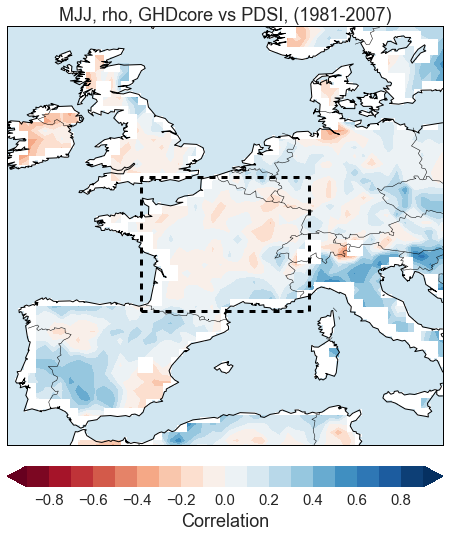

In [85]:
# Individual Plots for GHD Core and GHD mean (Temp, Prec, PDSI)
for ifile in enumerate(ghd_all_names[1:2]):
    print(ifile)
    
    # Pull GHD Site Coordinates (if specific site)
    #        Dummy Coorindates for Core and Composite Index
    if ifile[1] in ['GHDcore','GHDmean']:
        lat_site = 0.
        lon_site = 0.
        print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    else:
        # Pull out correct lat/lon for this site
        lat_site = df_sitelocs.Latitude[ifile[1]]
        lon_site = df_sitelocs.Longitude[ifile[1]]
        print(ifile[1]+': '+np.str(lat_site)+', '+np.str(lon_site))

    # TEMPERATURE
    # Pull out current correlation field
    corr_field = rho_ghd_temp[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs Temp, ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.temp.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

    # PRECIPITATION
    # Pull out current correlation field
    corr_field = rho_ghd_prec[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs Prec, ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.prec.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator

    # PDSI
    # Pull out current correlation field
    corr_field = rho_ghd_pdsi[ifile[0],:,:];
    
    # (1) SETUP FIGURE
    title_txt = mons_ave_txt+', rho, '+ifile[1]+' vs PDSI, ('+np.str(yr1[0])+'-'+np.str(yr2[0])+')'
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    # (2) SETUP PROJECTION
    m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
    # (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    # draw parallels.
    parallels = np.arange(0.,90,10.)
    #m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    # draw meridians
    meridians = np.arange(180.,360.,10.)
    #m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
    # (4) COMPUTE MAP PROJECTION COORDINATES
    x, y = m(lon_map, lat_map) # compute map proj coordinates.
    # (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
    clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
    cs = m.contourf(x,y,corr_field,clevs,cmap=plt.cm.RdBu,extend="both")
    m.drawmapboundary(fill_color='#99ffff')
    m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
    # (6) PLOT RECTANGLE OVER THE REGION
    plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
    # (7) DRAW SITE LOCATION
    x_loc, y_loc = m(lon_site,lat_site)
    m.scatter(x_loc,y_loc,65,marker='o',color=site_color)
    # (8) ADD COLORBAR AND TITLE
    cbar = m.colorbar(cs,location='bottom',pad="5%")
    cbar.set_label('Correlation',fontsize=18)
    plt.title(title_txt,fontdict)
    # (9) SAVE TO OUTPUT
    plt.show()
    out_txt = '../figures/step03/ghd.vs.pdsi.corr.'+ifile[1]+'.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
    fig.savefig(out_txt, format='eps', dpi=150) # vector graphics for adobe illustrator


    


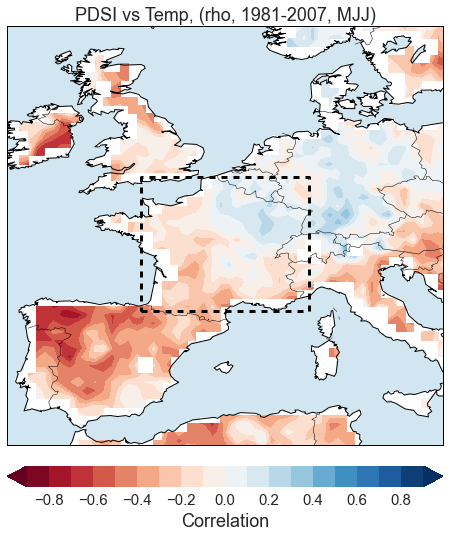

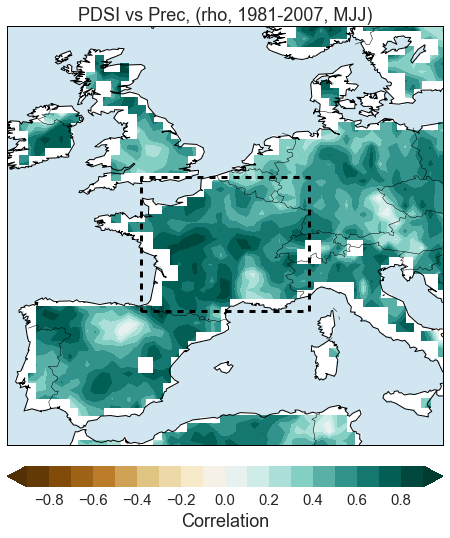

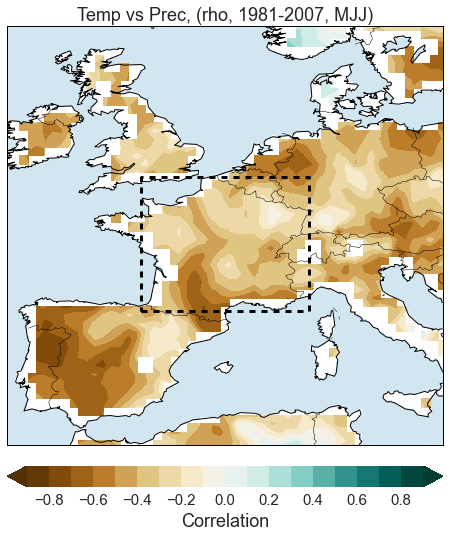

In [86]:
# CRU Climate Correlations Map

# Set Map Limits and coordinates for mapping
lon_map = lon[i_lon]; lat_map = lat[i_lat];

#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

#site_color = np.float64([140,140,140])/255
site_color = np.float64([0,0,0])/255

# PDSI vs Temp CORRELATION MAP
# Title
fontdict = {'fontsize': 18}

# MAP UP PDSI CORRELATION
# (1) SETUP FIGURE
title_txt = 'PDSI vs Temp, (rho, '+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')'
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# (2) SETUP PROJECTION
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
# (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
# (4) COMPUTE MAP PROJECTION COORDINATES
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
cs = m.contourf(x,y,rho_pdsi_vs_temp,clevs,cmap=plt.cm.RdBu,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# (7) DRAW SITE LOCATION
#x_loc, y_loc = m(lon_site,lat_site)
#m.scatter(x_loc,y_loc,35,marker='o',color=site_color)
# (8) ADD COLORBAR AND TITLE
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Correlation',fontsize=18)
plt.title(title_txt,fontdict)
# (9) SAVE TO OUTPUT
plt.show()
out_txt = '../figures/step03/cru321.corr.pdsi.vs.temp.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator

# MAP UP PDSI VS PREC CORRELATION
# (1) SETUP FIGURE
title_txt = 'PDSI vs Prec, (rho, '+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')'
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# (2) SETUP PROJECTION
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
# (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
# (4) COMPUTE MAP PROJECTION COORDINATES
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
cs = m.contourf(x,y,rho_pdsi_vs_pre,clevs,cmap=plt.cm.BrBG,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# (7) DRAW SITE LOCATION
#x_loc, y_loc = m(lon_site,lat_site)
#m.scatter(x_loc,y_loc,35,marker='o',color=site_color)
# (8) ADD COLORBAR AND TITLE
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Correlation',fontsize=18)
plt.title(title_txt,fontdict)
# (9) SAVE TO OUTPUT
plt.show()
out_txt = '../figures/step03/cru321.corr.pdsi.vs.prec.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator

# MAP UP Temp VS Prec CORRELATION
# (1) SETUP FIGURE
title_txt = 'Temp vs Prec, (rho, '+np.str(yr1[0])+'-'+np.str(yr2[0])+', '+mons_ave_txt+')'
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# (2) SETUP PROJECTION
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
# (3) DRAW BOUNDARIES AND PARALLELS (IF DESIRED)
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
# (4) COMPUTE MAP PROJECTION COORDINATES
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# (5) DRAW FILLED CONTOURS, BOUNDARY, AND LAND-SEA MASK
clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]; clevs=np.asarray(clevs); clevs=clevs*1
cs = m.contourf(x,y,rho_temp_vs_pre,clevs,cmap=plt.cm.BrBG,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# (7) DRAW SITE LOCATION
#x_loc, y_loc = m(lon_site,lat_site)
#m.scatter(x_loc,y_loc,35,marker='o',color=site_color)
# (8) ADD COLORBAR AND TITLE
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('Correlation',fontsize=18)
plt.title(title_txt,fontdict)
# (9) SAVE TO OUTPUT
plt.show()
out_txt = '../figures/step03/cru321.corr.temp.vs.prec.'+mons_ave_txt+'.'+np.str(yr1[0])+'-'+np.str(yr2[0])+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator



